# Centerless Grinding Process Modeling
Model development is a critical phase in data science projects, where mathematical algorithms are trained to capture patterns and relationships in the preprocessed data. This phase requires careful consideration of model selection, training strategies, and evaluation methods to ensure reliable predictions. The modeling workflow encompasses several key components:

**Model Selection**

- Evaluation of various regression algorithms suitable for continuous output prediction
- Consideration of model complexity versus interpretability trade-offs
- Assessment of computational requirements and scalability
- Selection of models based on problem characteristics and data structure

**Model Training**

- Implementation of cross-validation strategies to ensure robust model evaluation
- Hyperparameter tuning using systematic optimization approaches (e.g., grid search, random search)
- Training multiple model variants to compare performance
- Monitoring for overfitting and underfitting during training

**Performance Metrics**

- Selection of appropriate evaluation metrics for regression tasks (e.g., RMSE, MAE, $R^2$)
- Implementation of domain-specific performance indicators
- Comparison of metrics across different models and validation sets
- Statistical significance testing of performance differences

**Model Validation**

- Assessment of model generalization on hold-out test sets
- Analysis of prediction errors and their distribution
- Validation against domain knowledge and physical constraints
- Evaluation of model robustness across different operating conditions

**Model Interpretability**

- Analysis of feature importance and their impact on predictions
- Visualization of model decision boundaries and prediction patterns
- Assessment of model behavior in edge cases
- Documentation of model limitations and assumptions

**Model Deployment Considerations**

- Evaluation of model computational efficiency
- Assessment of model maintainability and updating requirements
- Consideration of integration requirements with existing systems
- Documentation of model usage guidelines and limitations

**Iterative Refinement**

- Feedback incorporation from initial model performance
- Fine-tuning of model parameters based on validation results
- Implementation of ensemble methods if appropriate
- Continuous model improvement based on new insights

This modeling phase aims to develop a reliable predictive system that not only achieves high accuracy but also provides meaningful insights into the centerless grinding process. The selected approach must balance statistical performance with practical applicability in manufacturing settings.

## Selected Models

The regression models chosen for evaluation include:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Polynomial Regression
- K-Nearest Neighbors (KNN) Regression
- Support Vector Regressor (SVR)
- Decision Tree Regression
- Random Forest Regression
- AdaBoost Regression
- Gradient Boosting Regression
- Extreme Gradient Boosting Regression (XGB)
- Multilayer Perceptron (MLP) Regression

These models provide a mix of linear and nonlinear approaches, enabling a comprehensive assessment of their predictive capabilities. The details of their implementation and performance evaluation will be discussed in the following sections of the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
# from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

2025-03-07 11:56:04.813125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preparation

In [2]:
df_comp = pd.read_csv('CenterlessGrindingDataPreprocessed.csv')
df_comp = df_comp.drop(['Unnamed: 0'], axis=1)
df_comp.head()

,wp_height,blade_angle,feed_vel,tot_diam_remov,wp_lenght,wp_diameter,grind_wheel_diam,contr_wheel_diam,contr_wheel_vel,grind_spec_energy,edge_force_comp,grit_stiff,Hi_fidelity_output
0,0.381000,0.267226,1.515967,-0.540471,1.723171,-0.164494,-0.391149,0.814013,1.563328,1.431395,-0.747201,-0.023258,0.337581
1,-1.159070,0.267226,1.519350,-0.472901,1.645364,1.373885,-1.236877,-0.960324,0.638102,-0.693074,-0.856300,-0.132356,-0.151096
2,-1.617455,0.267226,-0.049475,-0.878322,0.453733,0.808093,1.410251,-0.041018,0.355629,1.119321,-1.492287,0.025795,-0.691365
3,0.645713,0.267226,-0.315034,-0.675612,-1.566711,1.424629,0.327720,-0.015646,-0.221158,0.677005,-1.077035,0.475722,-0.538889
4,-1.609843,0.267226,0.567061,-0.067479,-1.071114,0.352246,1.373885,-1.300307,1.189516,-0.879980,-1.406023,-1.060120,1.222961


In [3]:
df = df_comp.copy()
X = df.drop(['Hi_fidelity_output'], axis=1)
y = df['Hi_fidelity_output']

In [4]:
seed = 1297409

### Model evaluation techniques: Hold-out procedure and cross-validation
To assess the performance of the models, I implement both the hold-out procedure and cross-validation. The hold-out method involves splitting the dataset into separate training, validation, and test sets. In this case, 60% of the data is used for training, while the remaining 40% is split between validation (20%) and test sets (20%). This approach is simple and efficient but can be sensitive to the specific data split, especially when the dataset is not large.

On the other hand, cross-validation (CV) is a more robust technique that mitigates this issue by repeatedly splitting the dataset into different training and validation subsets. A common approach is k-fold cross-validation, where the dataset is divided into k equally sized folds. One fold is used for validation while the remaining k-1 folds are used for training. This process repeats k times so that each fold serves as validation once. For this study, I employ 10-fold cross-validation, a widely accepted choice in the literature. Given the relatively limited dataset size, cross-validation is an appropriate method to ensure stable performance estimates. However, for completeness, I include both methodologies in the evaluation process.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed) # 60% training and 40% test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed) # 50% validation and 50% test

X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

In [6]:
X_train.shape, X_val.shape, X_test.shape

((2457, 12), (819, 12), (820, 12))

In [7]:
n_folds = 10
cv_folds = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

In [8]:
def compute_cross_val(model, X, y, cv=10, model_name="Model"):
    
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="r2") # cross_val_score returns r2
    # cv_scores = - cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error") # cross_val_score returns negative RMSE
    cv_df = pd.DataFrame({'CV score': [cv_scores.mean()]}, index=[model_name])

    return cv_scores, cv_df


## Evaluation Metrics

To quantify model performance, I use four key regression metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and the coefficient of determination ($\text{R}^2$). Each metric provides different insights into model accuracy and error distribution.

- Mean Absolute Error (MAE): Measures the average absolute difference between predicted and actual values. It is easy to interpret but does not emphasize larger errors.

- Mean Squared Error (MSE): Penalizes larger errors more heavily than MAE by squaring differences. This makes it sensitive to outliers.

- Root Mean Squared Error (RMSE): The square root of MSE, bringing the error back to the same unit as the target variable. It is useful for assessing overall model performance.

- coefficient of determination ($\text{R}^2$): Indicates how well the model explains the variance in the data. A value close to 1 suggests a good fit, while values near 0 indicate poor predictive power.

Given the nature of the problem, all four metrics are relevant. MAE and RMSE provide insights into absolute errors, while MSE highlights larger deviations. $\text{R}^2$ offers an overall goodness-of-fit measure. Using a combination of these metrics ensures a comprehensive evaluation of model performance.

In [9]:
def compute_metrics(model, X_train, y_train, X_test, y_test):
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics train
    train_metrics = {
        'MAE': mean_absolute_error(y_train, y_pred_train),
        'MSE': mean_squared_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'R2': r2_score(y_train, y_pred_train)
    }

    # Metrics validation
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R2': r2_score(y_test, y_pred_test)
    }

    # DataFrame with metrics
    metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])

    return metrics_df

## Train Error vs Validation Error and Confidence Intervals

To ensure a proper assessment of the model's generalization ability, I consider both train error and validation error. This is crucial to detecting overfitting (where the model performs well on training data but poorly on validation data due to excessive complexity) and underfitting (where the model is too simple to capture patterns in the data, leading to poor performance on both training and validation sets). By analyzing both errors, I can identify whether a model is too complex or too simplistic and make necessary adjustments.

Additionally, I retain all computed metrics for each fold during cross-validation. This allows me to estimate confidence intervals for the final evaluation of each model, providing a more reliable measure of performance variability. This step ensures that model comparisons are statistically robust rather than dependent on a single data split.

In [10]:
cv_all_scores = {} # Dictionary to store all cross-validation scores
train_metrics = {} # Dictionary to store all training metrics
test_metrics = {} # Dictionary to store all test metrics

## Linear Regression - baseline model
In the initial phase of my modeling approach, linear regression was chosen as the baseline model due to its fundamental characteristics and practical advantages. This choice was motivated by several key considerations:
The model offers distinct advantages for my initial analysis:

- Interpretability: The direct relationship between features and predictions allows for clear understanding of the model's behavior
- Computational Efficiency: Fast training and prediction capabilities make it ideal for rapid prototyping
- Feature Importance Analysis: Model coefficients provide immediate insight into the relative impact of each process parameter
- Mathematical Transparency: Clear mathematical foundation enables straightforward validation and debugging

However, we acknowledge several inherent limitations:

- Linearity Assumption: The model presumes linear relationships between process parameters and workpiece roundness
- Sensitivity to Multicollinearity: Highly correlated features can destabilize the model
- Limited Complexity: May not capture intricate non-linear relationships inherent in the grinding process

My implementation strategy follows a two-stage approach:

- Initial Model: Using only original process parameters to establish a fundamental performance baseline
- Enhanced Model: Incorporating feature interactions through polynomial terms to capture more complex relationships

In [11]:
LinearRegression_model = LinearRegression()
LinearRegression_model.fit(X_train, y_train)
model_name = "Linear regression"

LinearRegression_metrics_df = compute_metrics(LinearRegression_model, X_train, y_train, X_test, y_test)
LinearRegression_all_cv_df, LinearRegression_cv_df = compute_cross_val(LinearRegression_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = LinearRegression_all_cv_df
train_metrics[model_name] = LinearRegression_metrics_df.loc['Train']
test_metrics[model_name] = LinearRegression_metrics_df.loc['Test']

display(LinearRegression_metrics_df) 
display(LinearRegression_cv_df)

,MAE,MSE,RMSE,R2
Train,0.521163,0.924873,0.961703,0.209159
Test,0.520560,0.556000,0.745654,0.265945


,CV score
Linear regression,0.236942


The low cross-validation score ($R^2$) indicates that the model fails to capture the data's complexity. Additionally, the significant gap between training and validation RMSE suggests that the model is overfitting. To understand feature importance, I plotted the linear regression model's weights in the barplot below. The grit stiffness variable appears to contribute minimally to the model's performance. To address the overfitting issue, I applied two regularization techniques. It would be particularly interesting to see if the Lasso model, which is known for embedded feature selection, eliminates the grit stiffness feature by reducing its weight to zero (as Lasso tends to produce sparse solutions).

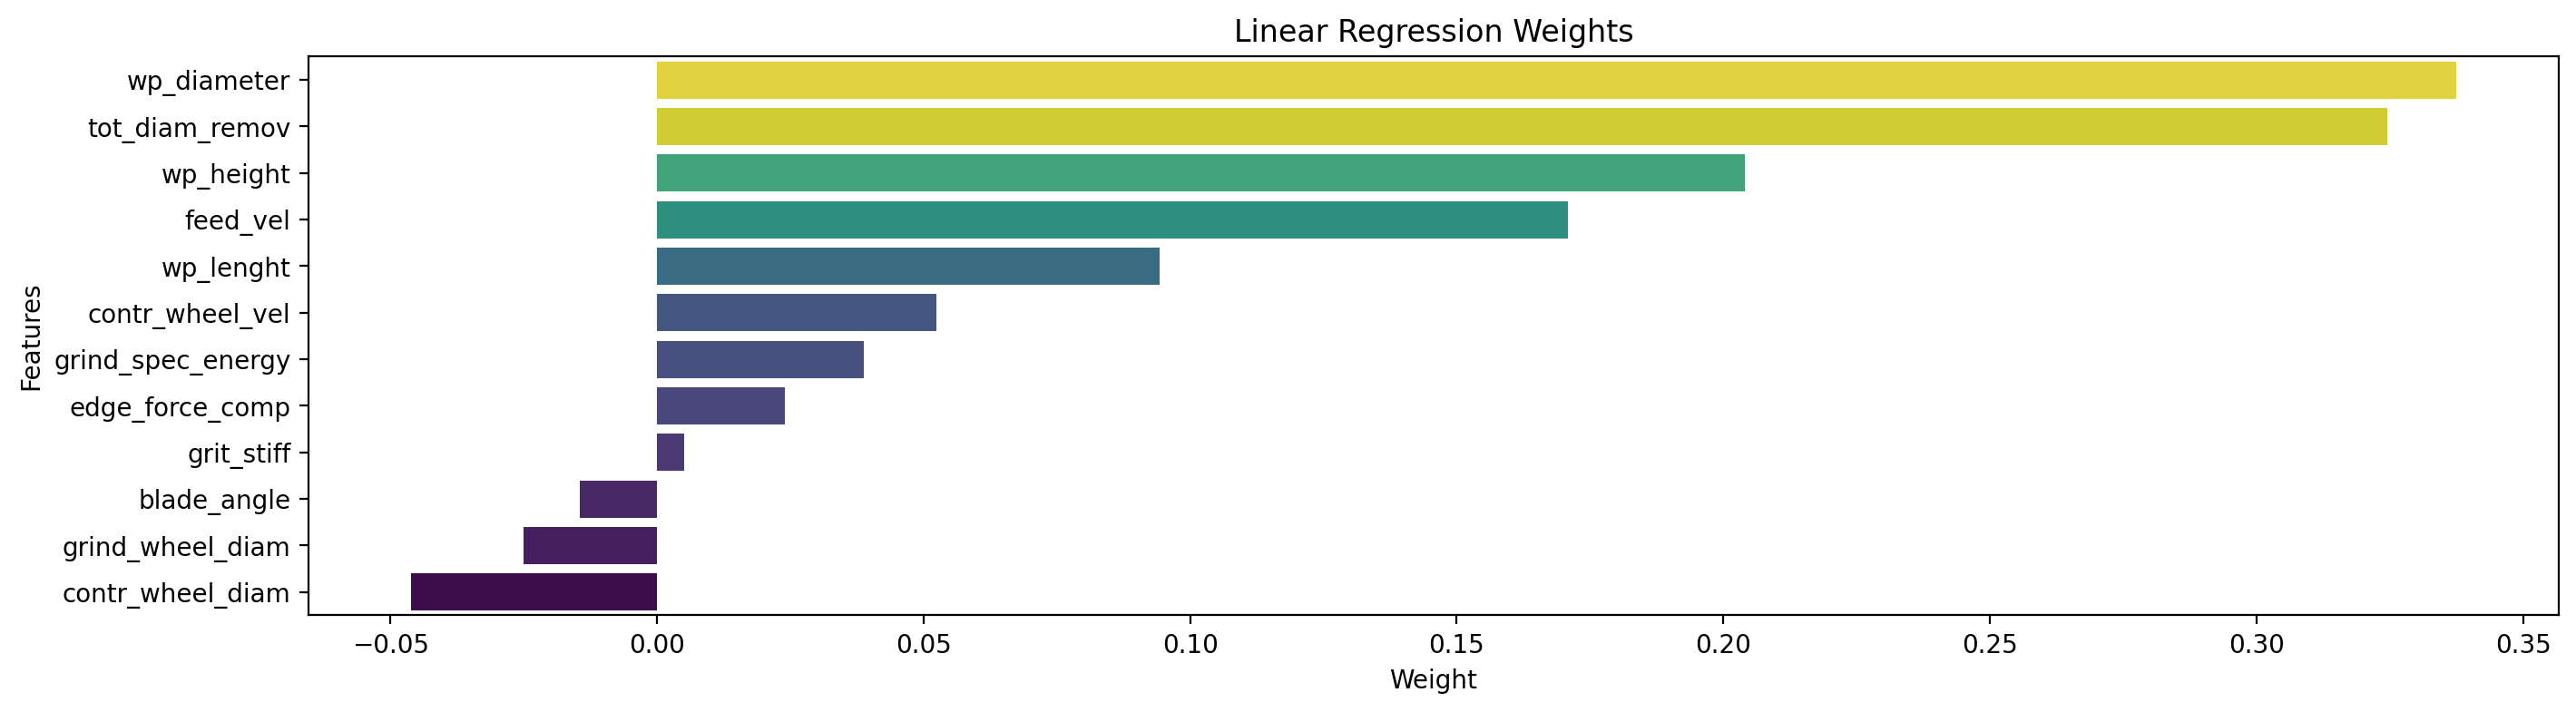

In [12]:
LinearRegression_weight = pd.DataFrame(LinearRegression_model.coef_, index=X_train.columns, columns=['Weight'])
LinearRegression_weight = LinearRegression_weight.sort_values(by='Weight', ascending=False)

plt.figure(figsize=(16, 4))
sns.barplot(x='Weight', y=LinearRegression_weight.index, data=LinearRegression_weight, palette='viridis', hue='Weight', dodge=False, legend=False)
plt.title('Linear Regression Weights')
plt.ylabel('Features')
plt.show()

## Ridge & Lasso regression

To address the overfitting issue, I implemented both Ridge and Lasso regression techniques. These regularization methods add a penalty term to the loss function: Ridge (L2) adds the squared magnitude of coefficients, while Lasso (L1) adds their absolute values. The key difference is that Lasso can drive coefficients exactly to zero, effectively performing feature selection. For both models, I "optimized" the regularization parameter ($\alpha$), selecting the value that minimized the validation error. This systematic approach helped find the optimal trade-off between model complexity and predictive performance, ensuring the models generalize well to unseen data.

### Ridge regression

In [13]:
Ridge_mse = []
Ridge_alpha = [0.01, 0.1, 1, 10, 100, 300, 500, 700, 1000]
for alpha in Ridge_alpha:
    Ridge_model = Ridge(alpha=alpha)
    Ridge_model.fit(X_train, y_train)
    y_pred = Ridge_model.predict(X_val)
    Ridge_mse.append(mean_squared_error(y_val, y_pred))

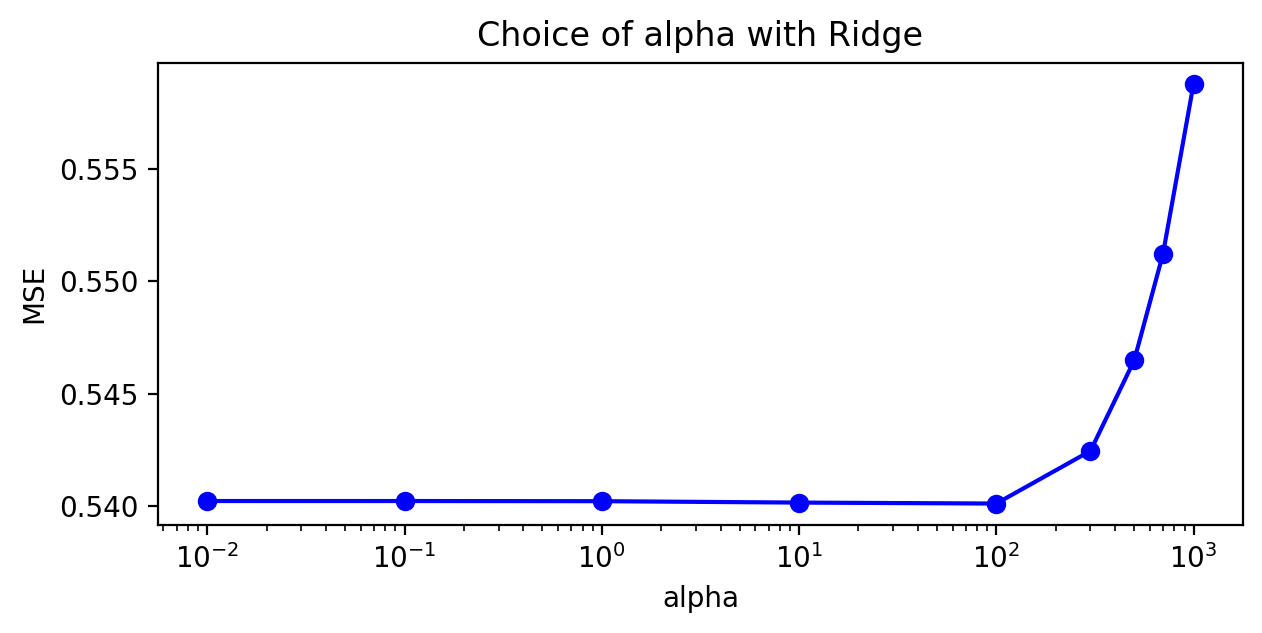

In [14]:
plt.figure(figsize=(7, 3))
plt.plot(Ridge_alpha, Ridge_mse, marker='o', color='b')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Choice of alpha with Ridge')
plt.show()

In [15]:
alpha = 100
RidgeRegression_model = Ridge(alpha=alpha)
RidgeRegression_model.fit(X_train, y_train)
model_name = "Ridge regression"

RidgeRegression_metrics_df = compute_metrics(RidgeRegression_model, X_train, y_train, X_test, y_test)
RidgeRegression_all_cv_df, RidgeRegression_cv_df = compute_cross_val(RidgeRegression_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = RidgeRegression_all_cv_df
train_metrics[model_name] = RidgeRegression_metrics_df.loc['Train']
test_metrics[model_name] = RidgeRegression_metrics_df.loc['Test']

display(RidgeRegression_metrics_df) 
display(RidgeRegression_cv_df)

,MAE,MSE,RMSE,R2
Train,0.521293,0.925594,0.962078,0.208542
Test,0.520982,0.555528,0.745338,0.266568


,CV score
Ridge regression,0.238629


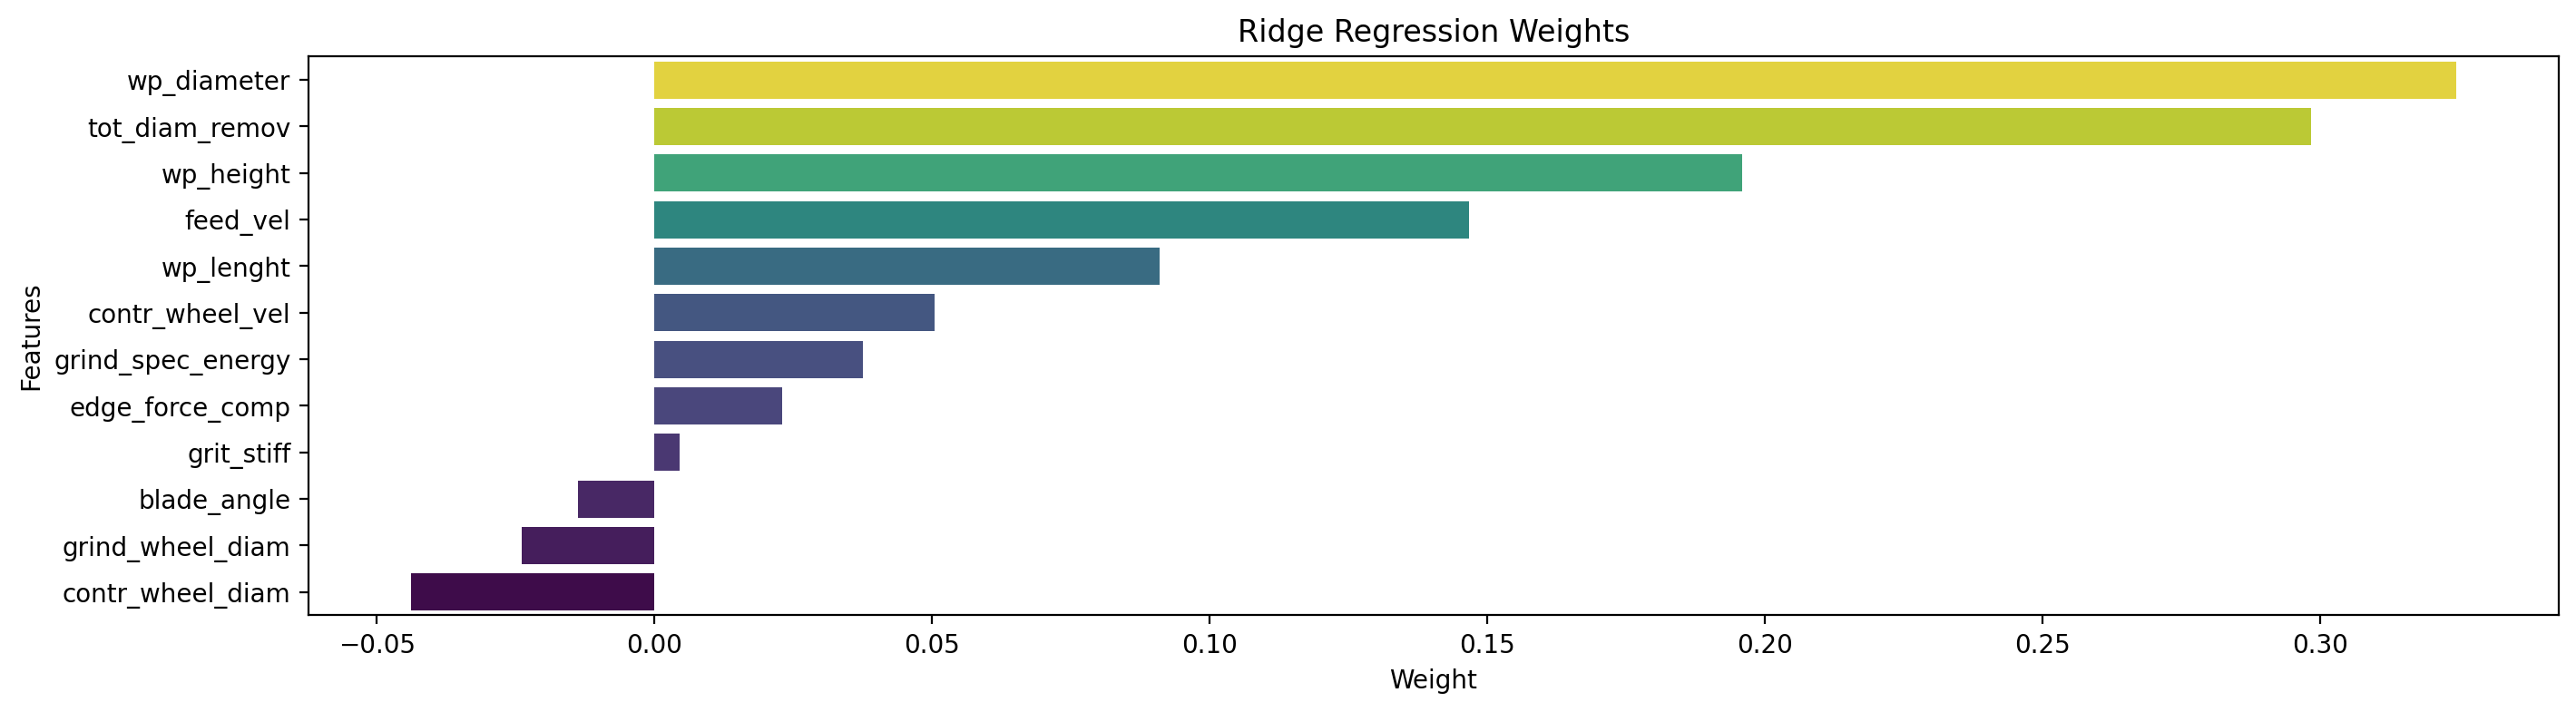

In [16]:
RidgeRegression_weight = pd.DataFrame(RidgeRegression_model.coef_, index=X_train.columns, columns=['Weight'])
RidgeRegression_weight = RidgeRegression_weight.sort_values(by='Weight', ascending=False)

plt.figure(figsize=(16, 4))
sns.barplot(x='Weight', y=RidgeRegression_weight.index, data=RidgeRegression_weight, palette='viridis', hue='Weight', dodge=False, legend=False)
plt.title('Ridge Regression Weights')
plt.ylabel('Features')
plt.show()

### Lasso regression

In [17]:
Lasso_mse = []
Lasso_alpha = [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2]

for alpha in Lasso_alpha:
    Lasso_model = Lasso(alpha=alpha)
    Lasso_model.fit(X_train, y_train)
    y_pred = Lasso_model.predict(X_val)
    Lasso_mse.append(mean_squared_error(y_val, y_pred))

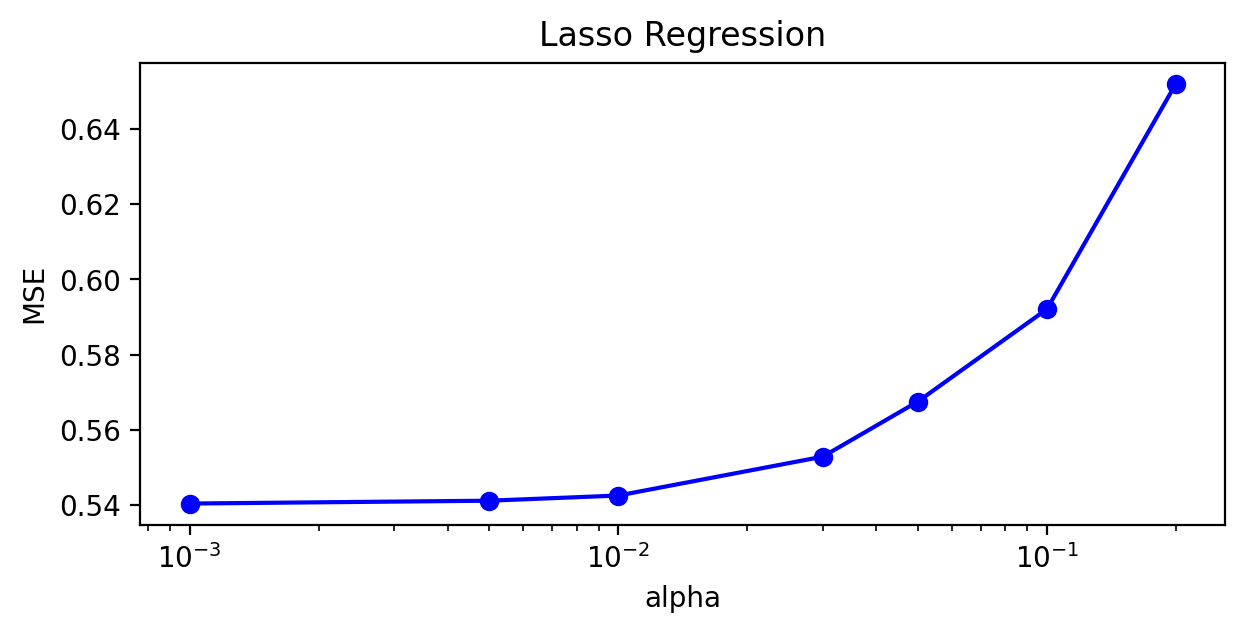

In [18]:
plt.figure(figsize=(7, 3))
plt.plot(Lasso_alpha, Lasso_mse, marker='o', color='b')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso Regression')
plt.show()

In [19]:
alpha = 0.001
LassoRegression_model = Lasso(alpha=alpha)
LassoRegression_model.fit(X_train, y_train)
model_name = "Lasso regression"

LassoRegression_metrics_df = compute_metrics(LassoRegression_model, X_train, y_train, X_test, y_test)
LassoRegression_all_cv_df, LassoRegression_cv_df = compute_cross_val(LassoRegression_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = LassoRegression_all_cv_df
train_metrics[model_name] = LassoRegression_metrics_df.loc['Train']
test_metrics[model_name] = LassoRegression_metrics_df.loc['Test']

display(LassoRegression_metrics_df) 
display(LassoRegression_cv_df)

,MAE,MSE,RMSE,R2
Train,0.521126,0.924889,0.961712,0.209145
Test,0.520570,0.556012,0.745662,0.265930


,CV score
Lasso regression,0.237159


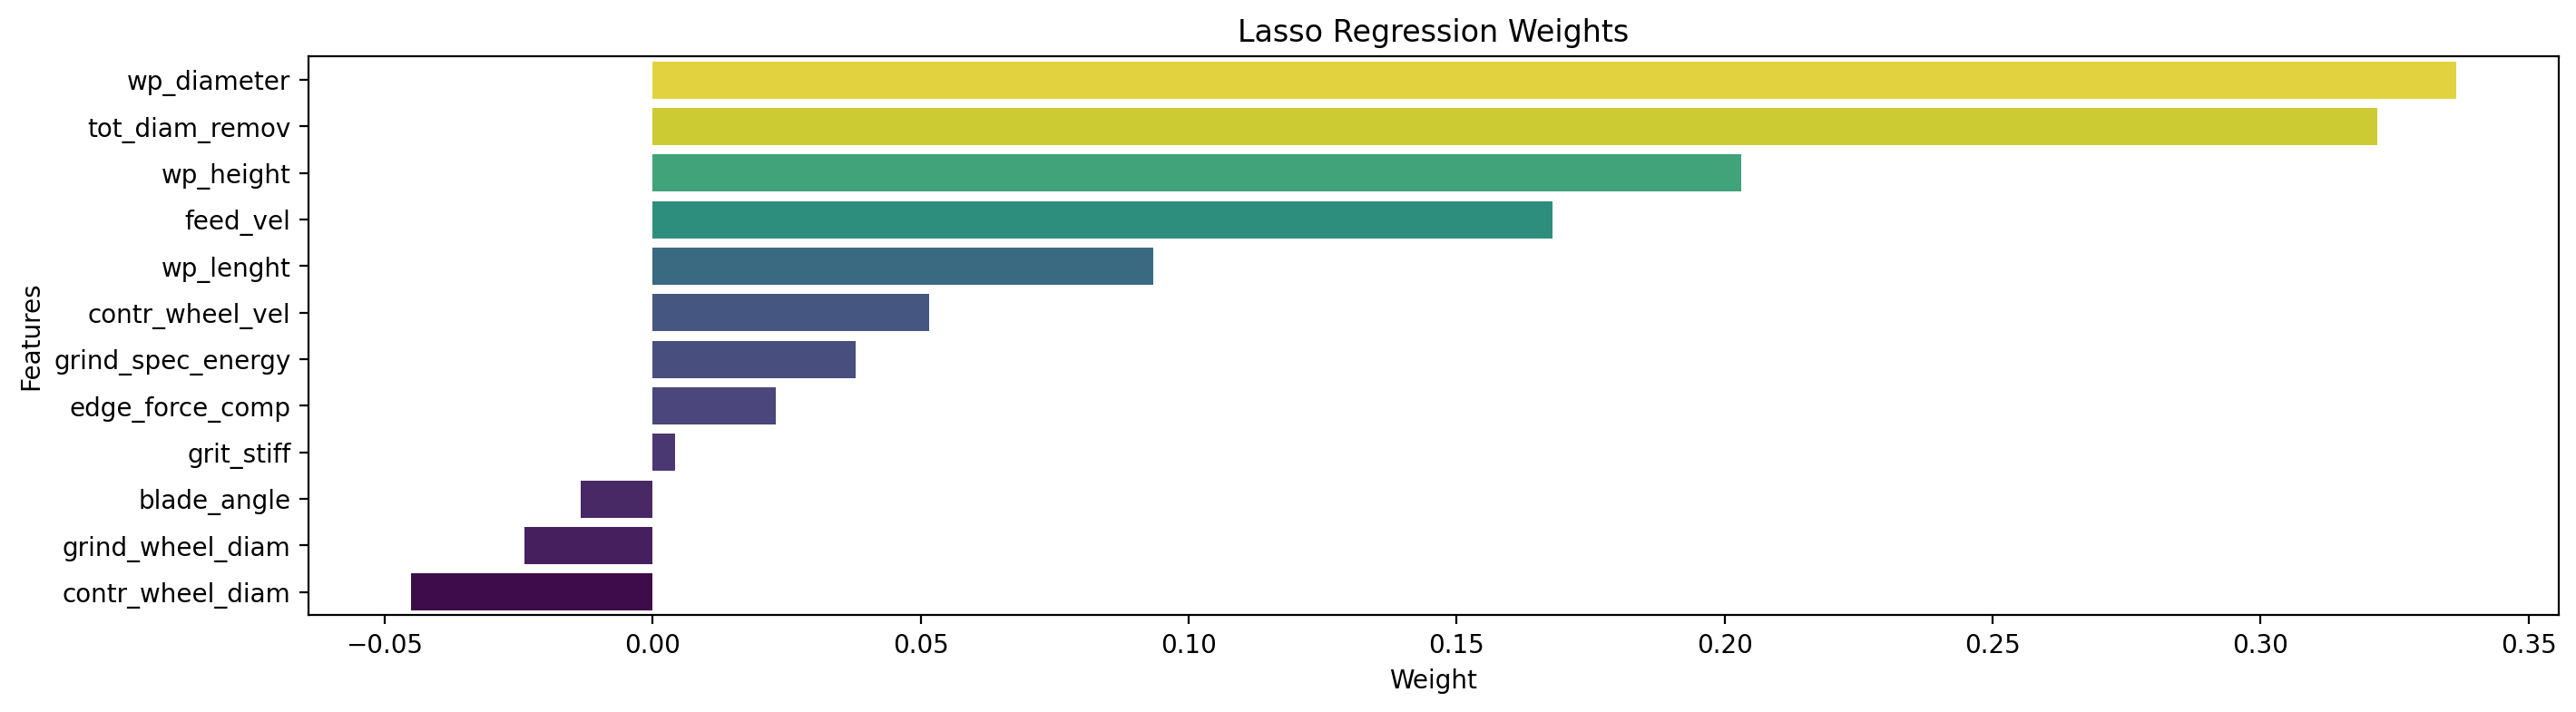

In [20]:
LassoRegression_weight = pd.DataFrame(LassoRegression_model.coef_, index=X_train.columns, columns=['Weight'])
LassoRegression_weight = LassoRegression_weight.sort_values(by='Weight', ascending=False)

plt.figure(figsize=(16, 4))
sns.barplot(x='Weight', y=LassoRegression_weight.index, data=LassoRegression_weight, palette='viridis', hue='Weight', dodge=False, legend=False)
plt.title('Lasso Regression Weights')
plt.ylabel('Features')
plt.show()

The analysis reveals some interesting insights about feature importance. Although grit stiffness shows lower importance compared to other features, its removal through Lasso regularization (as $\alpha$ increases) actually leads to decreased model performance. This suggests that, despite its smaller contribution, the variable still captures meaningful patterns in the data. Furthermore, an noteworthy observation emerges regarding feed velocity: while this feature was initially flagged for potential elimination by the variance threshold feature selection method (see the data inspection notebook), it proves to be quite significant for the model's predictive capability. This finding highlights the importance of validating feature selection decisions through multiple approaches, as statistical measures alone may not fully capture a variable's practical significance in the modeling context.

### Linear, Ridge & Lasso weight comparison
For academic purposes, I compared the coefficient weights across all three methods (Linear, Ridge, and Lasso regression). As expected, the pattern of coefficients provides insights into how each model handles feature importance. It's worth noting that higher regularization parameters ($\alpha$) would have resulted in more pronounced effects: increased coefficient shrinkage in both Ridge and Lasso models, and more zero-valued coefficients specifically in Lasso due to its L1 penalty term. This comparison illustrates the fundamental differences in how these regularization techniques influence model parameters while maintaining predictive performance.

In [21]:
regressors_weight = pd.concat([LinearRegression_weight, RidgeRegression_weight, LassoRegression_weight], axis=1)
regressors_weight.columns = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
regressors_weight

,Linear Regression,Ridge Regression,Lasso Regression
wp_diameter,0.337510,0.324608,0.336520
tot_diam_remov,0.324509,0.298345,0.321718
wp_height,0.204101,0.196017,0.203114
feed_vel,0.170806,0.146783,0.167868
wp_lenght,0.094253,0.091034,0.093305
contr_wheel_vel,0.052413,0.050396,0.051502
grind_spec_energy,0.038879,0.037519,0.037862
edge_force_comp,0.024056,0.022969,0.023046
grit_stiff,0.005168,0.004608,0.004176
blade_angle,-0.014437,-0.013701,-0.013449


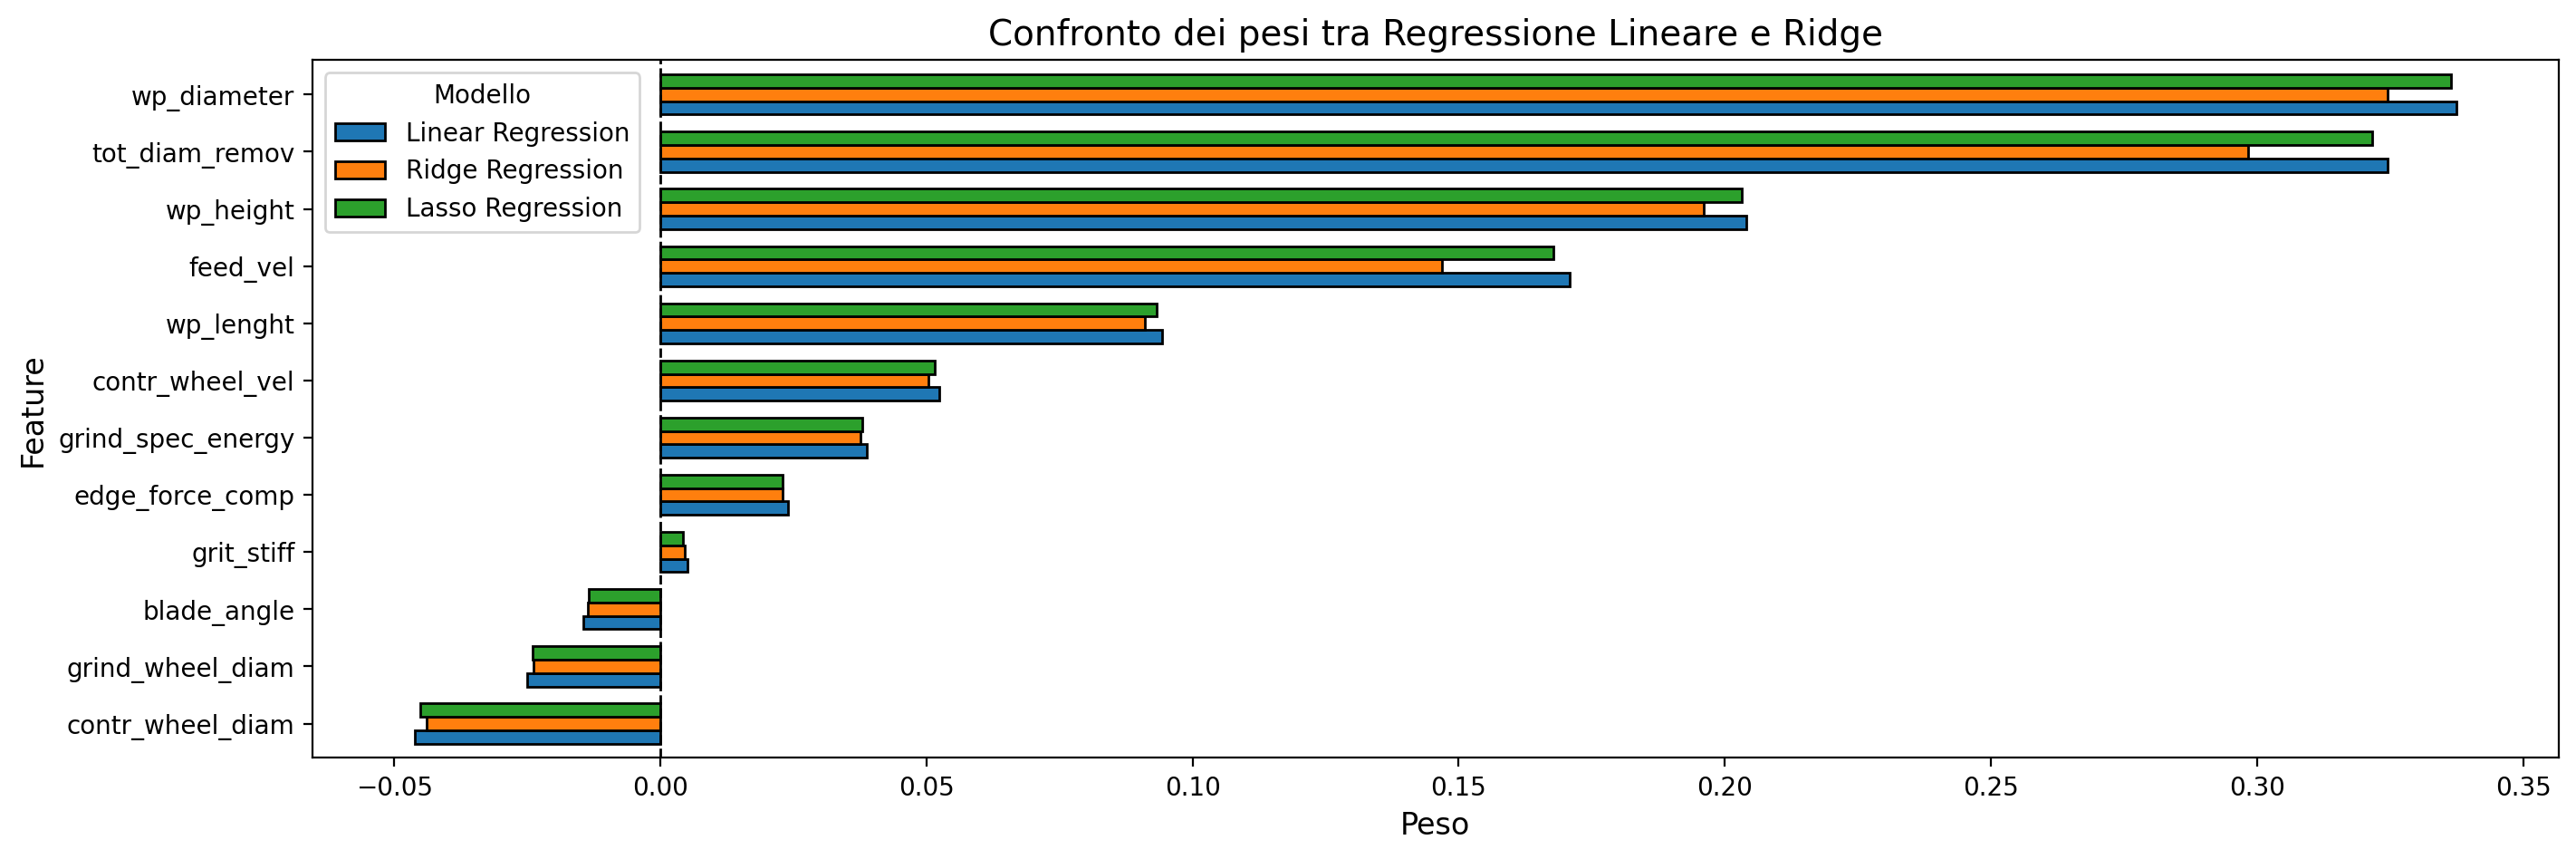

In [22]:
regressors_weight = regressors_weight.sort_values(by="Linear Regression", ascending=True)
regressors_weight.plot(kind="barh", figsize=(16, 5), width=0.7, edgecolor="black")
plt.title("Confronto dei pesi tra Regressione Lineare e Ridge", fontsize=14)
plt.xlabel("Peso", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.axvline(0, color="black", linewidth=1, linestyle="--")  # Linea verticale per separare positivi e negativi
plt.legend(title="Modello")
plt.show()

## Polynomial regression
The models using only the original features fail to achieve satisfactory performance, suggesting that the underlying relationships might be more complex than initially assumed. To test this hypothesis, I expanded the feature space by increasing the model order to include second-order interactions between features (creating new features as products of pairs of original features). This polynomial expansion could potentially reveal important feature interactions that the simpler models failed to capture. If this approach yields better results, it would demonstrate the presence of significant interactions between the original features that should be considered in future analyses. Such findings would provide valuable insights into the complex relationships within the problem domain and guide future feature engineering efforts.

In [25]:
polynomial = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X2_train = polynomial.fit_transform(X_train)
X2_val = polynomial.fit_transform(X_val)
X2_test = polynomial.transform(X_test)
X2_cv = np.concatenate((X2_train, X2_val), axis=0)

In [26]:
PolyRegression_model = LinearRegression()
PolyRegression_model.fit(X2_train, y_train)
model_name = "Polynomial regression"

PolyRegression_metrics_df = compute_metrics(PolyRegression_model, X2_train, y_train, X2_test, y_test)
PolyRegression_all_cv_df, PolyRegression_cv_df = compute_cross_val(PolyRegression_model, X2_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = PolyRegression_all_cv_df
train_metrics[model_name] = PolyRegression_metrics_df.loc['Train']
test_metrics[model_name] = PolyRegression_metrics_df.loc['Test']

display(PolyRegression_metrics_df) 
display(PolyRegression_cv_df)

,MAE,MSE,RMSE,R2
Train,0.486888,0.766752,0.875644,0.344365
Test,0.502175,0.503982,0.709917,0.334621


,CV score
Polynomial regression,0.300472


The superior performance achieved through cross-validation compared to a simple linear regression model suggests that the underlying relationships between features are more intricate than a purely linear approach can capture. To further investigate this, I examined the 20 highest-weighted coefficients, some of which are associated with second-order features. Their prominence in the model highlights the importance of feature interactions in predicting roundness, reinforcing the idea that nonlinear dependencies play a crucial role in capturing the true structure of the data. These findings underscore the necessity of incorporating interaction terms in future modeling efforts to improve predictive accuracy.

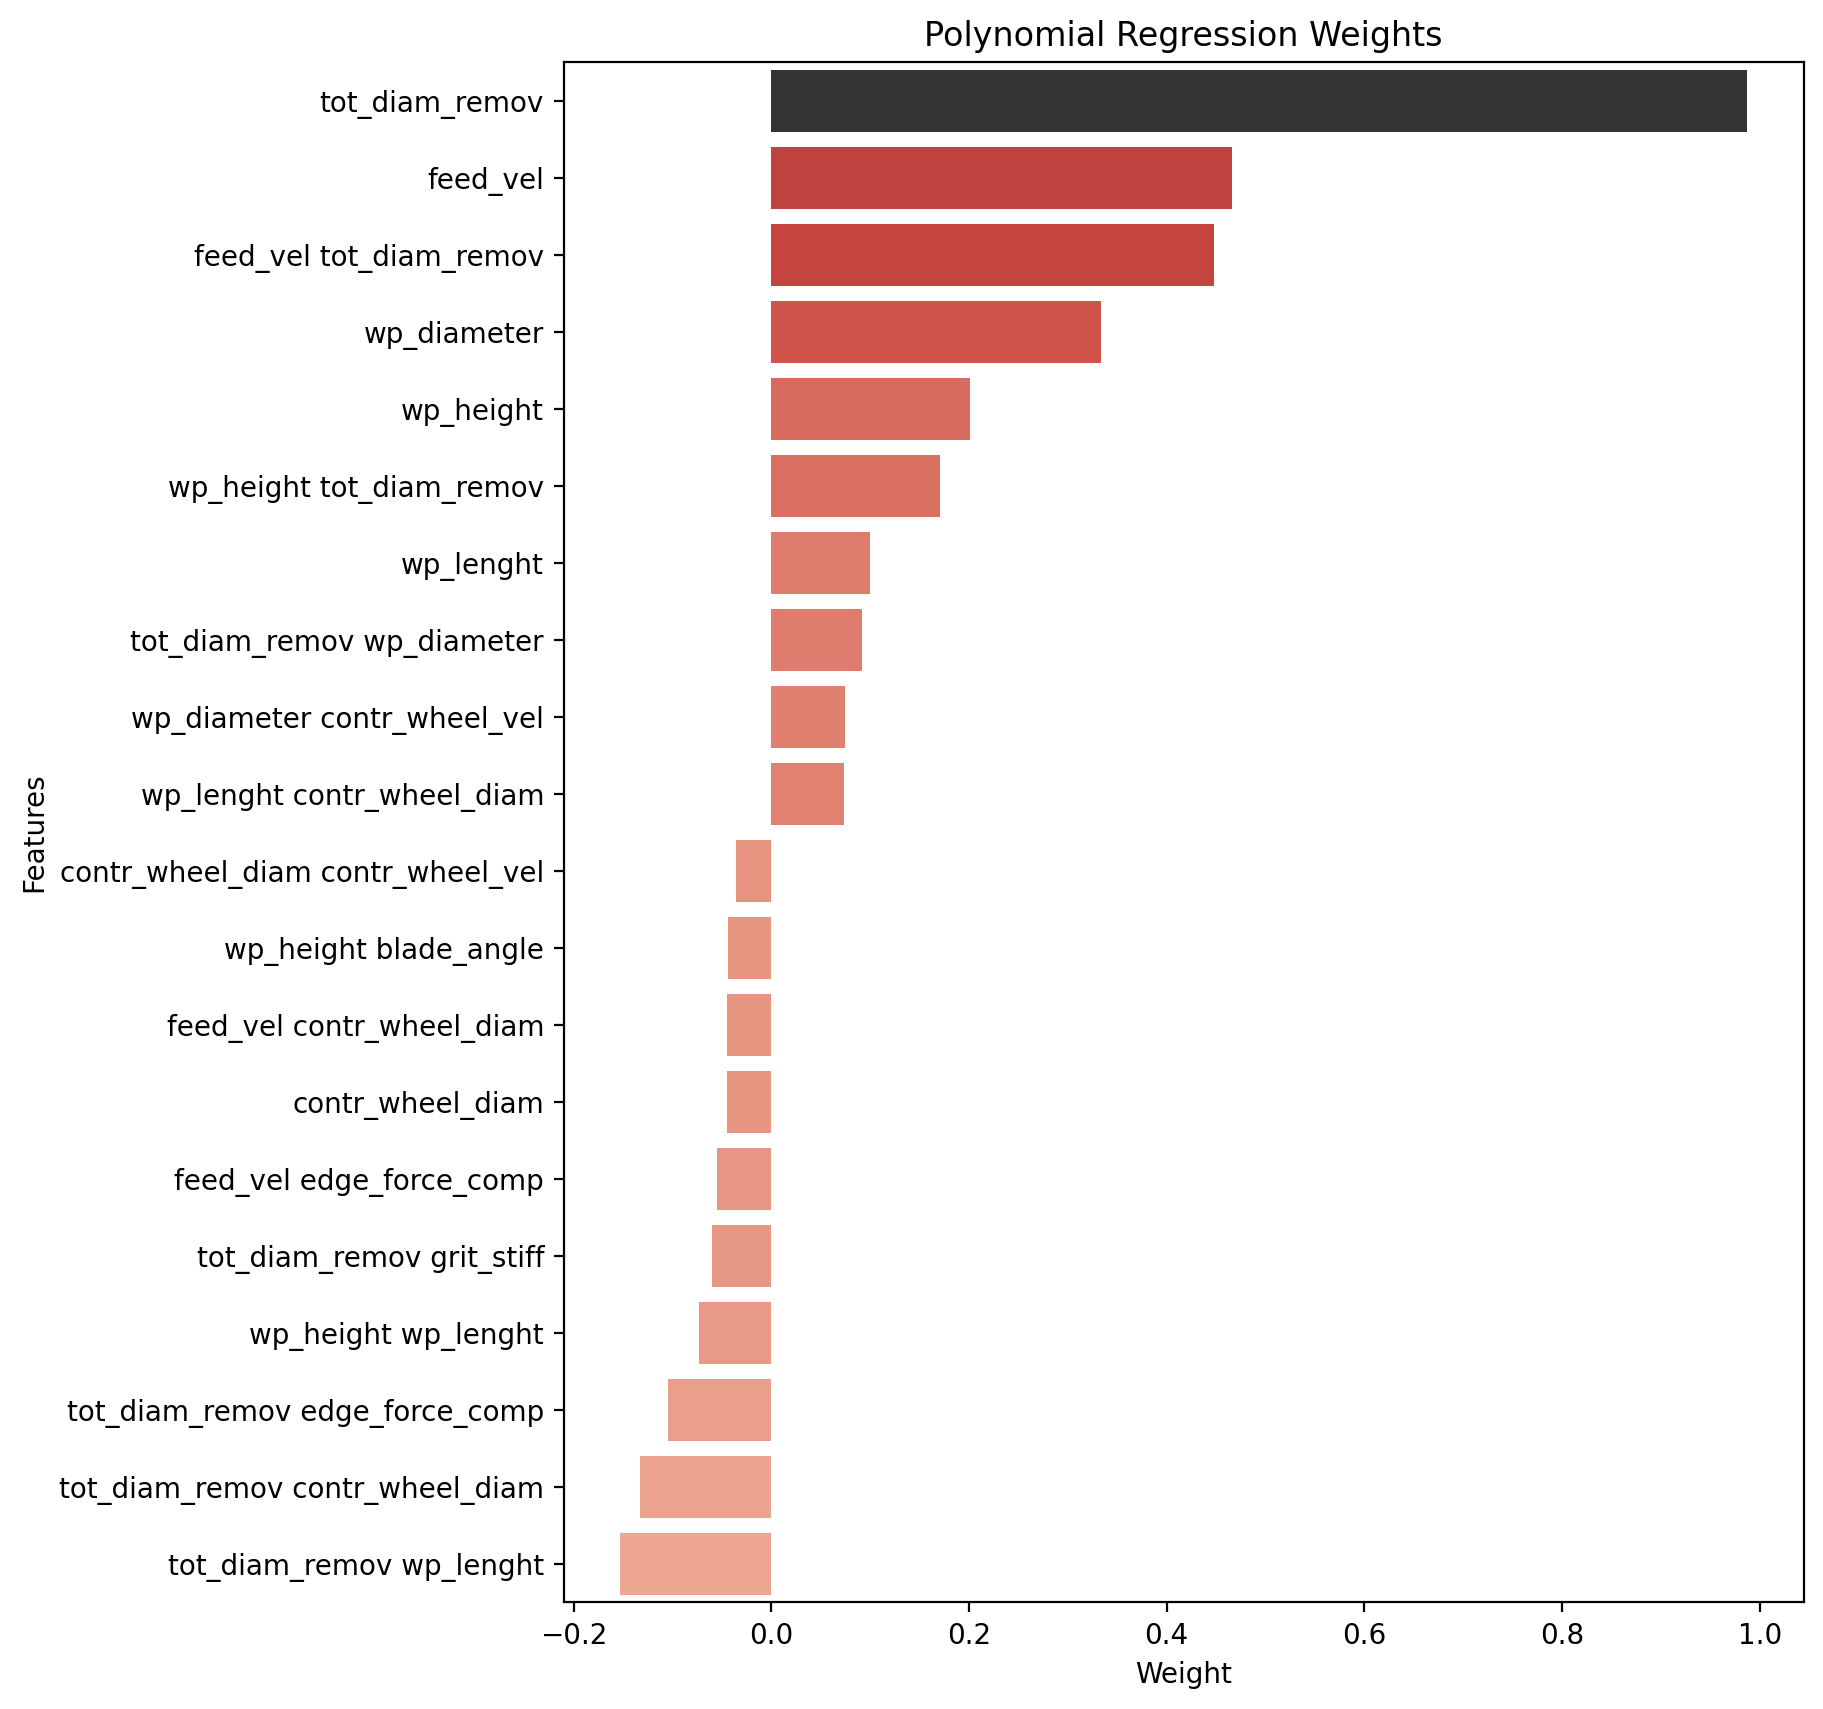

In [27]:
PolyRegression_weight = pd.DataFrame({'Features':polynomial.get_feature_names_out(), 'Weight':PolyRegression_model.coef_})
PolyRegression_weight = PolyRegression_weight.set_index('Features')
PolyRegression_weight = PolyRegression_weight.sort_values(by=['Weight'], ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x='Weight', y='Features', data = pd.concat([PolyRegression_weight.head(10), PolyRegression_weight.tail(10)], axis=0), palette='Reds_d', hue='Weight', dodge=False, legend=False)
plt.title('Polynomial Regression Weights')
plt.show()


## K-NN regression
The K-Nearest Neighbors (KNN) regression model was selected for its ability to capture complex, non-linear relationships without making assumptions about the underlying data distribution. This non-parametric approach can be particularly valuable when the relationship between features and target variable doesn't follow a clear mathematical pattern. However, KNN comes with notable disadvantages: it can be computationally expensive for large datasets, suffers from the curse of dimensionality, and lacks interpretability compared to linear models. Before implementation, I performed hyperparameter tuning to determine the optimal number of neighbors (K). This process involved training and validating multiple models with different K values and plotting their respective errors. The resulting error curve helped identify the value of K that balances the trade-off between underfitting (high K) and overfitting (low K), optimizing the model's predictive performance.

In [28]:
n_NN = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mse_NN_train = []
mse_NN_val = []

for n in n_NN:
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    mse_NN_train.append(mse_train)
    mse_NN_val.append(mse_val)

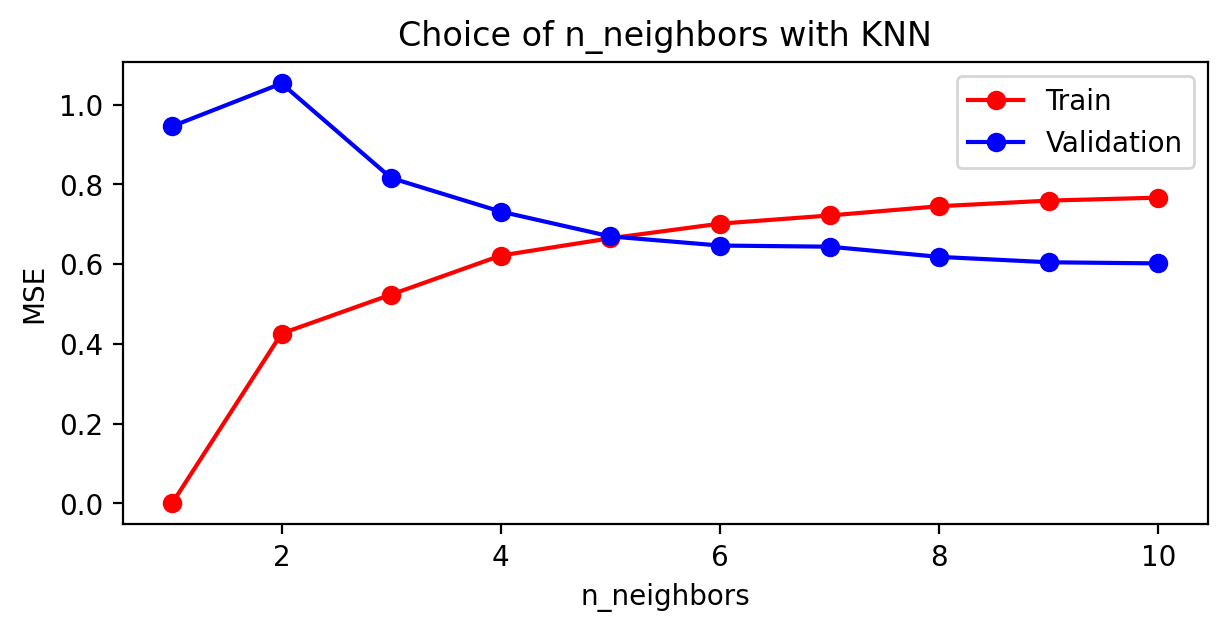

In [29]:
plt.figure(figsize=(7, 3))
plt.plot(n_NN, mse_NN_train, marker='o', color='r', label='Train')
plt.plot(n_NN, mse_NN_val, marker='o', color='b', label='Validation')
plt.xlabel('n_neighbors')
plt.ylabel('MSE')
plt.title('Choice of n_neighbors with KNN')
plt.legend()
plt.show()

In [31]:
KNNRegression_model = KNeighborsRegressor(n_neighbors=5) 
KNNRegression_model.fit(X_train, y_train)
model_name = "KNN regression"

KNNRegression_metrics_df = compute_metrics(KNNRegression_model, X_train, y_train, X_test, y_test)
KNNRegression_all_cv_df, KNNRegression_cv_df = compute_cross_val(KNNRegression_model, X2_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = KNNRegression_all_cv_df
train_metrics[model_name] = KNNRegression_metrics_df.loc['Train']
test_metrics[model_name] = KNNRegression_metrics_df.loc['Test']

display(KNNRegression_metrics_df) 
display(KNNRegression_cv_df)

,MAE,MSE,RMSE,R2
Train,0.443183,0.664774,0.815337,0.431565
Test,0.527003,0.555914,0.745597,0.266059


,CV score
KNN regression,0.136773


## SVR
The Support Vector Regressor (SVR) model was implemented for its ability to handle non-linear relationships by mapping data to higher-dimensional spaces through kernel functions, while maintaining robust generalization properties. SVR aims to find a function with at most $\varepsilon$ deviation from the target values, effectively creating a tube around the regression function where errors are tolerated. This approach makes SVR particularly resilient to outliers when using appropriate parameters. However, SVR presents several limitations: it scales poorly with dataset size, requiring significant computational resources for large datasets; parameter selection (including kernel choice, regularization parameter C, and epsilon) can be challenging and heavily influences performance; and the model offers limited interpretability compared to simpler regression techniques. SVR is also sensitive to feature scaling, necessitating proper preprocessing steps. Despite these challenges, SVR can provide excellent performance for medium-sized datasets with complex non-linear relationships, especially when robustness to outliers is required and when the relationship between features and target variables isn't easily captured by simpler models.

In [32]:
SVR_model = SVR()
SVR_model.fit(X_train, y_train)
model_name = "SVR"

SVR_metrics_df = compute_metrics(SVR_model, X_train, y_train, X_test, y_test)
SVR_all_cv_df, SVR_cv_df = compute_cross_val(SVR_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = SVR_all_cv_df
train_metrics[model_name] = SVR_metrics_df.loc['Train']
test_metrics[model_name] = SVR_metrics_df.loc['Test']

display(SVR_metrics_df) 
display(SVR_cv_df)

,MAE,MSE,RMSE,R2
Train,0.319144,0.711851,0.843712,0.391310
Test,0.404290,0.451404,0.671866,0.404038


,CV score
SVR,0.386059


## Decision tree
The Decision Tree regression model was implemented for its ability to capture non-linear relationships and feature interactions while providing interpretable results through its hierarchical structure. This model can effectively handle both numerical and categorical features without requiring data preprocessing. However, Decision Trees have significant limitations: they tend to overfit the training data, especially with increasing depth, and can be unstable where small data variations may result in completely different tree structures. Before implementation, I focused on tuning the maximum depth parameter to control model complexity. This involved training and validating multiple models with varying tree depths and plotting their respective errors to identify the optimal value. For other hyperparameters such as min_samples_split, min_samples_leaf, and criterion, comprehensive tuning is addressed in a separate notebook. At this stage, the primary goal is to conduct a general comparison between different model types to evaluate their relative performance in solving the problem at hand. Once the top-performing models are identified, a more precise and exhaustive hyperparameter optimization will be performed to maximize predictive accuracy.

In [33]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
RandomForest_mse_train = []
RandomForest_mse_val = []
for max_depth in max_depths:
    RandomForest_model = RandomForestRegressor(
        criterion='squared_error', 
        max_depth=max_depth, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features=None, 
        max_leaf_nodes=None, 
        random_state=42
    )
    RandomForest_model.fit(X_train, y_train)
    y_pred_train = RandomForest_model.predict(X_train)
    y_pred_val = RandomForest_model.predict(X_val)
    RandomForest_mse_train.append(mean_squared_error(y_train, y_pred_train))
    RandomForest_mse_val.append(mean_squared_error(y_val, y_pred_val))

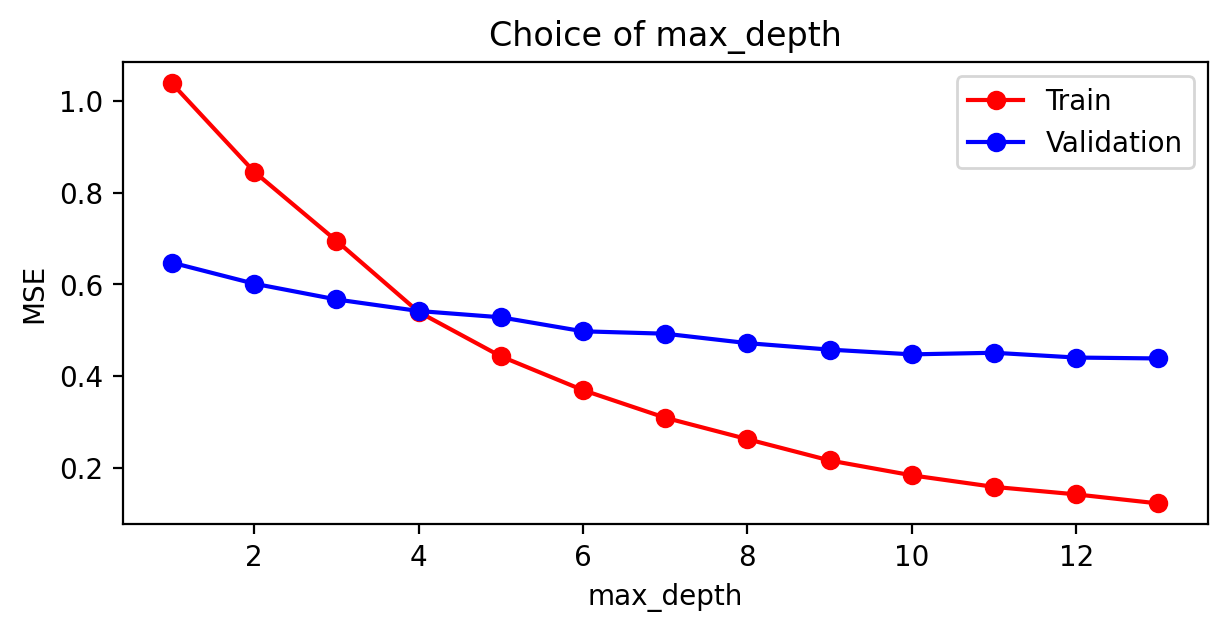

In [34]:
plt.figure(figsize=(7, 3))
plt.plot(max_depths, RandomForest_mse_train, marker='o', color='r')
plt.plot(max_depths, RandomForest_mse_val, marker='o', color='b')
#plt.xscale('log')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('Choice of max_depth')
plt.legend(['Train', 'Validation'])
plt.show()

In [35]:
RegressionTree_model = DecisionTreeRegressor(
    criterion='squared_error', 
    splitter='best', 
    max_depth=5, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features=None, 
    max_leaf_nodes=None, 
    random_state=42
    )
RegressionTree_model.fit(X_train, y_train)
model_name = "Regression tree"

RegressionTree_metrics_df = compute_metrics(RegressionTree_model, X_train, y_train, X_test, y_test)
RegressionTree_all_cv_df, RegressionTree_cv_df = compute_cross_val(RegressionTree_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = RegressionTree_all_cv_df
train_metrics[model_name] = RegressionTree_metrics_df.loc['Train']
test_metrics[model_name] = RegressionTree_metrics_df.loc['Test']

display(RegressionTree_metrics_df) 
display(RegressionTree_cv_df)

,MAE,MSE,RMSE,R2
Train,0.436208,0.407893,0.638665,0.651218
Test,0.471575,0.524115,0.723958,0.308042


,CV score
Regression tree,-0.194056


The results obtained from the Regression Tree are not particularly good in terms of predictive performance; however, for illustrative purposes, it's still valuable to evaluate the feature importance assigned by the model. Decision Trees offer an intuitive method for assessing variable importance through various mechanisms: primarily by calculating how much each feature contributes to impurity (or variance, in regression cases) reduction during tree splits. This metric reflects how frequently a feature is used for split decisions and how significant the resulting error reduction is. Features that appear more frequently in the upper nodes of the tree and produce greater variance reductions tend to be considered more important. This interpretation approach represents one of the main advantages of tree-based models compared to other algorithms that may be more complex but less transparent.

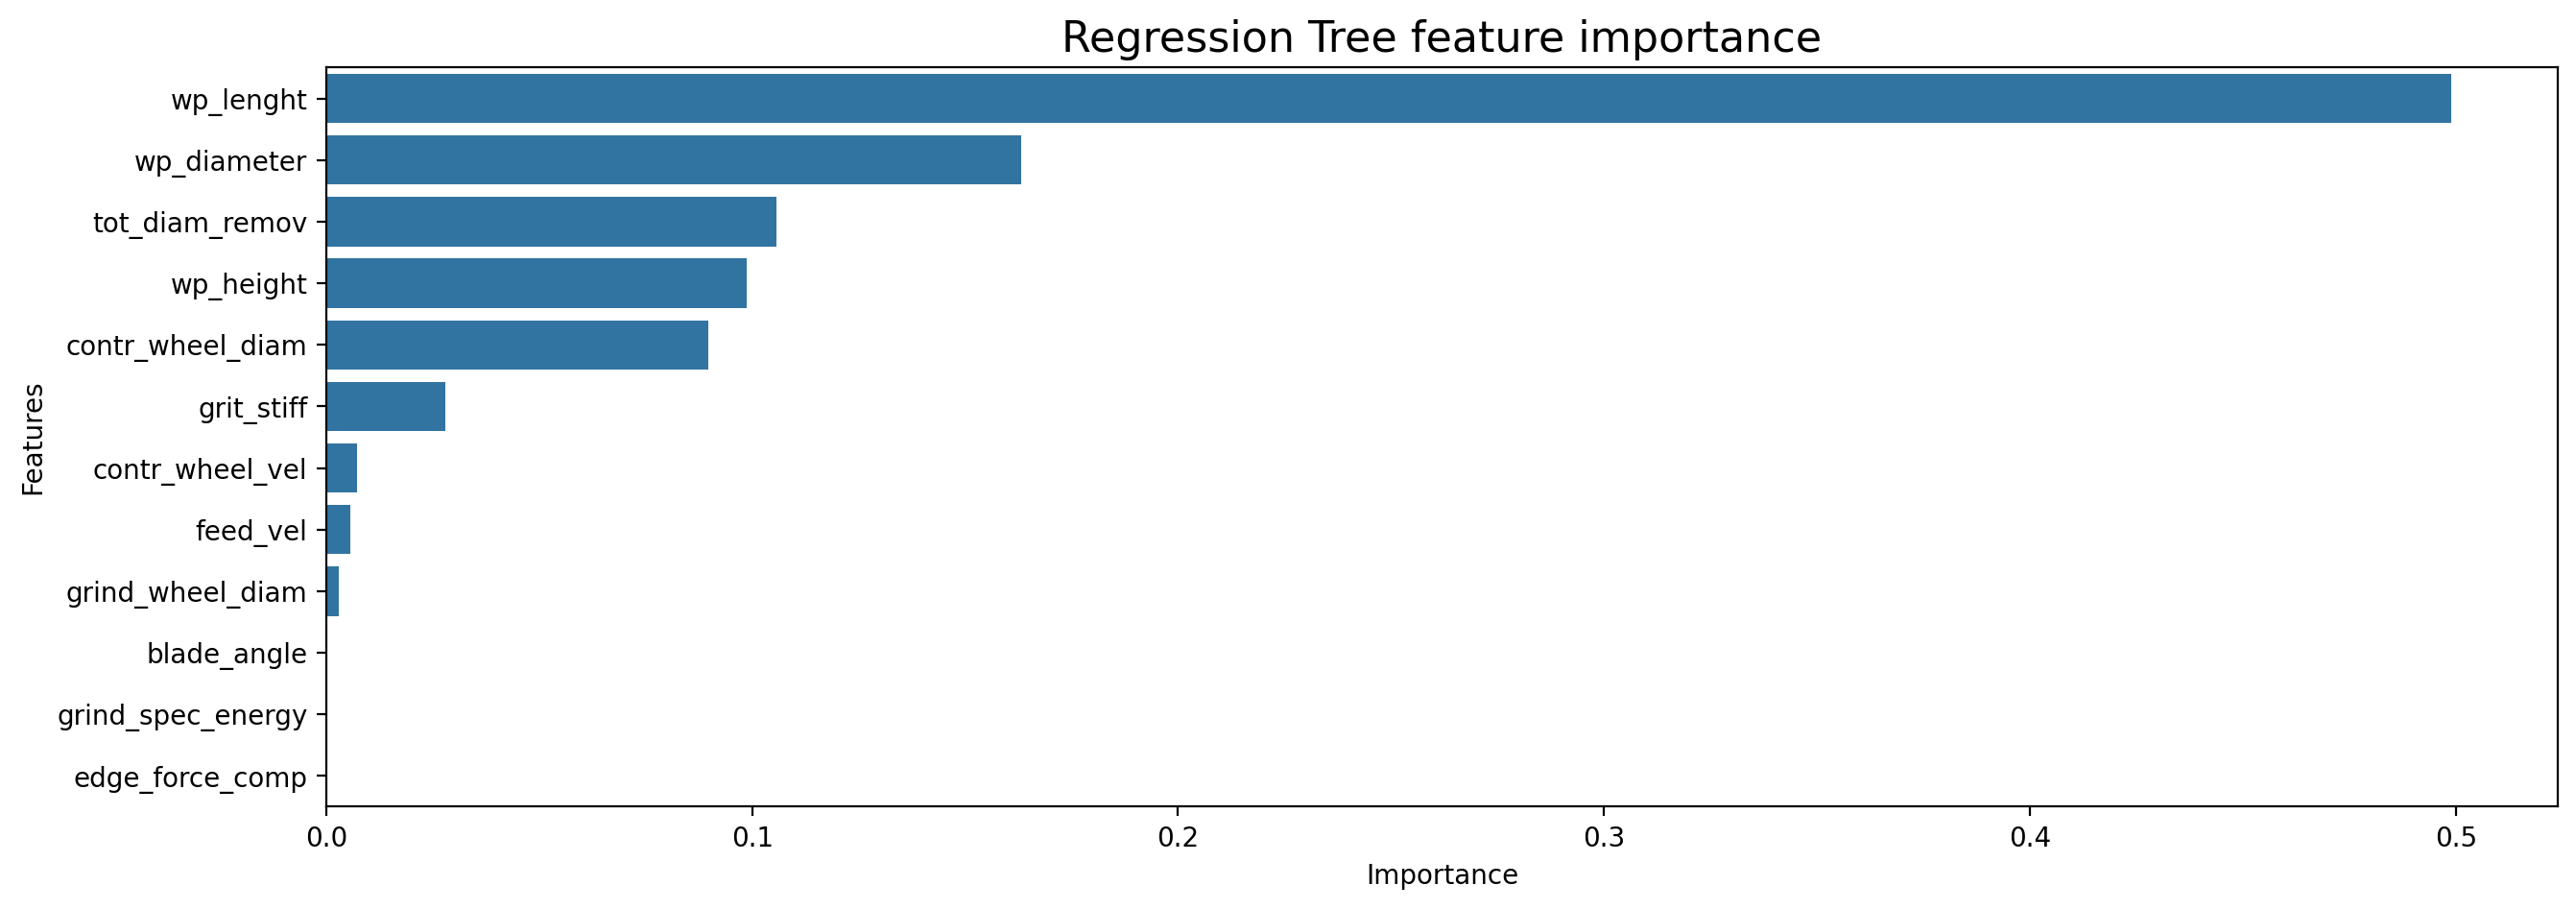

In [36]:
feature_importance = pd.DataFrame({
    'Features': X_train.columns, 
    'Importance': RegressionTree_model.feature_importances_
    })

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=feature_importance.Importance, y=feature_importance.Features, data=feature_importance)
plt.title('Regression Tree feature importance', fontsize=16)
plt.show()

## Ensamble methods
Ensemble methods combine multiple base models to create a more powerful predictive system, addressing the limitations of individual algorithms. Bagging techniques, like Random Forest, train models on random data subsets with replacement and average their predictions, reducing variance and preventing overfitting. Boosting approaches, including AdaBoost, Gradient Boosting, and XGBoost, work sequentially by giving more weight to previously misclassified instances, with each new model correcting errors from previous ones. While Random Forest provides robust performance through diversified decision trees, AdaBoost focuses on difficult samples through weighted learning. Gradient Boosting optimizes arbitrary differentiable loss functions by adding models that follow the negative gradient, and XGBoost enhances this further with regularization and system optimizations. These ensemble techniques are particularly valuable when individual models struggle with complex relationships or when maximum predictive performance is required.

### Random forest
The Random Forest regression model was selected for its ability to overcome many limitations of single Decision Trees while maintaining their advantages. By aggregating predictions from multiple trees trained on random subsets of data and features, Random Forests significantly reduce overfitting and increase prediction stability. This ensemble method typically offers better generalization, handles non-linear relationships effectively, and provides a measure of feature importance. However, Random Forests do present drawbacks: they are less interpretable than single trees, computationally more intensive, and can still struggle with highly dimensional data.

In [37]:
RandomForest_model = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features=1.0, 
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=False,
    max_samples=None,
    warm_start=False,
    random_state=42
    )
RandomForest_model.fit(X_train, y_train)
model_name = "Random forest"

RandomForest_metrics_df = compute_metrics(RandomForest_model, X_train, y_train, X_test, y_test)
RandomForest_all_cv_df, RandomForest_cv_df = compute_cross_val(RandomForest_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = RandomForest_all_cv_df
train_metrics[model_name] = RandomForest_metrics_df.loc['Train']
test_metrics[model_name] = RandomForest_metrics_df.loc['Test']

display(RandomForest_metrics_df) 
display(RandomForest_cv_df)

,MAE,MSE,RMSE,R2
Train,0.148696,0.104648,0.323493,0.910518
Test,0.388284,0.393306,0.627141,0.480741


,CV score
Random forest,0.425296


### AdaBoost
The AdaBoost regression model creates a powerful ensemble by sequentially combining multiple weak learners  (decision stumps - one-level decision trees). Unlike Random Forest which trains trees in parallel, AdaBoost works sequentially, adjusting weights after each iteration to focus subsequent models on previously misclassified instances. This adaptive approach allows the algorithm to progressively improve prediction accuracy in challenging regions of the feature space. However, AdaBoost does present notable limitations: it is particularly sensitive to noisy data and outliers, which can lead to overfitting, and tends to give excessive importance to outliers during the weight adjustment process. The algorithm requires careful implementation to maintain a balance between fitting difficult examples and avoiding noise amplification. Despite these challenges, AdaBoost offers excellent performance when properly tuned and can uncover subtle patterns that simpler models might miss, making it a valuable addition to the ensemble methods being evaluated in this analysis.

In [38]:
AdaBoost_model = AdaBoostRegressor(
    estimator=None, # decision tree
    n_estimators=100,
    learning_rate=1.0,
    loss='square', 
    random_state=42
    )
AdaBoost_model.fit(X_train, y_train)
model_name = "AdaBoost"

AdaBoost_metrics_df = compute_metrics(AdaBoost_model, X_train, y_train, X_test, y_test)
AdaBoost_all_cv_df, AdaBoost_cv_df = compute_cross_val(AdaBoost_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = AdaBoost_all_cv_df
train_metrics[model_name] = AdaBoost_metrics_df.loc['Train']
test_metrics[model_name] = AdaBoost_metrics_df.loc['Test']

display(AdaBoost_metrics_df) 
display(AdaBoost_cv_df)

,MAE,MSE,RMSE,R2
Train,0.589449,0.534206,0.730894,0.543210
Test,0.624702,0.708791,0.841897,0.064224


,CV score
AdaBoost,0.062101


### GradientBoosting
The Gradient Boosting regression model was implemented for its ability to build an ensemble of weak learners sequentially, with each new model specifically trained to correct the errors of its predecessors. Unlike AdaBoost which adjusts sample weights, Gradient Boosting fits each new model to the residual errors from the previous ensemble using gradient descent optimization. This approach allows the algorithm to gradually reduce bias in regions where prediction is difficult, resulting in highly accurate predictions when properly tuned. However, Gradient Boosting presents several limitations: it is prone to overfitting without proper regularization, computationally intensive due to its sequential nature, and requires careful parameter selection to achieve optimal results. The model is particularly sensitive to the learning rate, number of estimators, and tree depth, which govern the trade-off between fitting accuracy and generalization. Despite these challenges, Gradient Boosting consistently ranks among top-performing algorithms for structured data problems, offering excellent predictive power while maintaining reasonable interpretability through feature importance metrics.

In [39]:
GradientBoosting_model = GradientBoostingRegressor(
    loss='squared_error', 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1.0, 
    criterion='squared_error', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_depth=4, 
    min_impurity_decrease=0.0, 
    init=None, # dummy estimator
    random_state=42, 
    max_features=None, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001, 
    )
GradientBoosting_model.fit(X_train, y_train)
model_name = "GradientBoosting"

GradientBoosting_metrics_df = compute_metrics(GradientBoosting_model, X_train, y_train, X_test, y_test)
GradientBoosting_all_cv_df, GradientBoosting_cv_df = compute_cross_val(GradientBoosting_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = GradientBoosting_all_cv_df
train_metrics[model_name] = GradientBoosting_metrics_df.loc['Train']
test_metrics[model_name] = GradientBoosting_metrics_df.loc['Test']

display(GradientBoosting_metrics_df) 
display(GradientBoosting_cv_df)

,MAE,MSE,RMSE,R2
Train,0.274812,0.145347,0.381244,0.875716
Test,0.406167,0.482674,0.694748,0.362753


,CV score
GradientBoosting,0.457774


### XGBoost
The Extreme Gradient Boosting (XGBoost) regression model was selected for its sophisticated enhancement of the standard Gradient Boosting framework, incorporating advanced regularization techniques and system optimizations. Unlike traditional Gradient Boosting, XGBoost implements a more efficient second-order gradient optimization and adds regularization terms to control model complexity, significantly reducing overfitting risk. This algorithm excels at handling sparse data and offers built-in mechanisms to manage missing values. However, XGBoost does present certain limitations: it requires careful hyperparameter tuning across numerous parameters, demands more computational resources than simpler models, and can be challenging to interpret despite its feature importance metrics. The algorithm's complexity means that small changes in hyperparameters can lead to significant performance differences. Despite these challenges, XGBoost consistently ranks among the top-performing algorithms in machine learning competitions and real-world applications, particularly when predictive accuracy on structured data is the primary objective and sufficient computational resources are available.

In [40]:
XGB_model = XGBRegressor(
    booster='gbtree',
    device='cpu',
    verbosity=1,
    eta=0.3, # learning rate
    gamma=0,
    max_depth=6,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    sampling_method='uniform',
    reg_lambda=1, # L2 regularization param
    reg_alpha=0, # L1 regularization param
    )
XGB_model.fit(X_train, y_train)
model_name = "XBG"

XGB_metrics_df = compute_metrics(XGB_model, X_train, y_train, X_test, y_test)
XGB_all_cv_df, XGB_cv_df = compute_cross_val(XGB_model, X_cv, y_cv, cv=cv_folds, model_name=model_name)

cv_all_scores[model_name] = XGB_all_cv_df
train_metrics[model_name] = XGB_metrics_df.loc['Train']
test_metrics[model_name] = XGB_metrics_df.loc['Test']

display(XGB_metrics_df) 
display(XGB_cv_df)

,MAE,MSE,RMSE,R2
Train,0.056042,0.006531,0.080815,0.994415
Test,0.407202,0.469187,0.684972,0.380560


,CV score
XBG,0.452381


## MLP
The Multi-Layer Perceptron (MLP) regression model captures complex non-linear relationships through multiple interconnected layers of neurons, potentially modeling intricate patterns that simpler models might miss. Unlike traditional statistical approaches, MLP can automatically learn hierarchical representations from the data, with earlier layers typically capturing simpler features while deeper layers model higher-level abstractions. This neural network approach offers considerable flexibility in approximating virtually any continuous function given sufficient neurons and training data. However, MLP presents significant limitations: it requires extensive hyperparameter tuning (including network architecture, activation functions, and regularization parameters); tends to be computationally intensive during training; and often demands larger datasets to generalize effectively. The model also suffers from limited interpretability, functioning essentially as a 'black box' where understanding the contribution of individual features becomes challenging. Despite these drawbacks, MLP can provide superior performance for problems with complex, non-linear dependencies that other algorithms struggle to model, particularly when sufficient data is available to prevent overfitting.

For this implementation, a custom cross-validation framework was developed from scratch since scikit-learn's built-in cross-validation functionality was incompatible with the Keras-based neural network architecture. This custom solution enabled proper performance evaluation while maintaining the advantages of the deep learning framework.

In [41]:
# Function to create and compile the model
def create_MLP_model():
    model = Sequential([
        Dense(X_train.shape[1], activation="relu"),
        Dense(5, activation="relu"),
        Dense(5, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [42]:
mse_per_fold = []
r2_per_fold = []

for fold, (train_index, val_index) in enumerate(cv_folds.split(X_cv)):
    print(f'Fold {fold + 1}')
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train_fold, y_val_fold = y_cv.iloc[train_index], y_cv.iloc[val_index]
    
    # Create a new instance of the model for each fold
    MLP_model = create_MLP_model()
    
    # Train the model on the training fold
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    MLP_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model on the validation fold
    y_val_pred = MLP_model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    
    # Store the accuracy for this fold
    mse_per_fold.append(mse)
    r2_per_fold.append(r2)
    # print(f'mse for fold {fold + 1}: {mse:.2f}')
    print(f'r2 for fold {fold + 1}: {r2:.2f}')

#MLP_cv_df = pd.DataFrame({'CV score': [np.mean(mse_per_fold)]}, index=['MLP'])
MLP_cv_df = pd.DataFrame({'CV score': [np.mean(r2_per_fold)]}, index=['MLP'])



Fold 1
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 1: 0.33
Fold 2
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 2: 0.15
Fold 3
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 3: 0.34
Fold 4
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 4: 0.45
Fold 5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 5: 0.46
Fold 6
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 6: 0.25
Fold 7
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 7: 0.42
Fold 8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
r2 for fold 8: 0.33
Fold 9
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 9: 0.38
Fold 10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
r2 for fold 10: 0.32


In [43]:
MLP_model = create_MLP_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = MLP_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

model_name = "MLP"

MLP_metrics_df = compute_metrics(MLP_model, X_train, y_train, X_test, y_test)

cv_all_scores[model_name] = np.array(r2_per_fold)
train_metrics[model_name] = MLP_metrics_df.loc['Train']
test_metrics[model_name] = MLP_metrics_df.loc['Test']

display(MLP_metrics_df)
display(MLP_cv_df)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,MAE,MSE,RMSE,R2
Train,0.448182,0.752257,0.867328,0.356759
Test,0.449528,0.448948,0.670035,0.407281


,CV score
MLP,0.342357


## Results

In [44]:
train_metrics_df = pd.DataFrame.from_dict(train_metrics, orient='index')
train_metrics_df.insert(0, "Set", "Train")

test_metrics_df = pd.DataFrame.from_dict(test_metrics, orient='index')
test_metrics_df.insert(0, "Set", "Test")

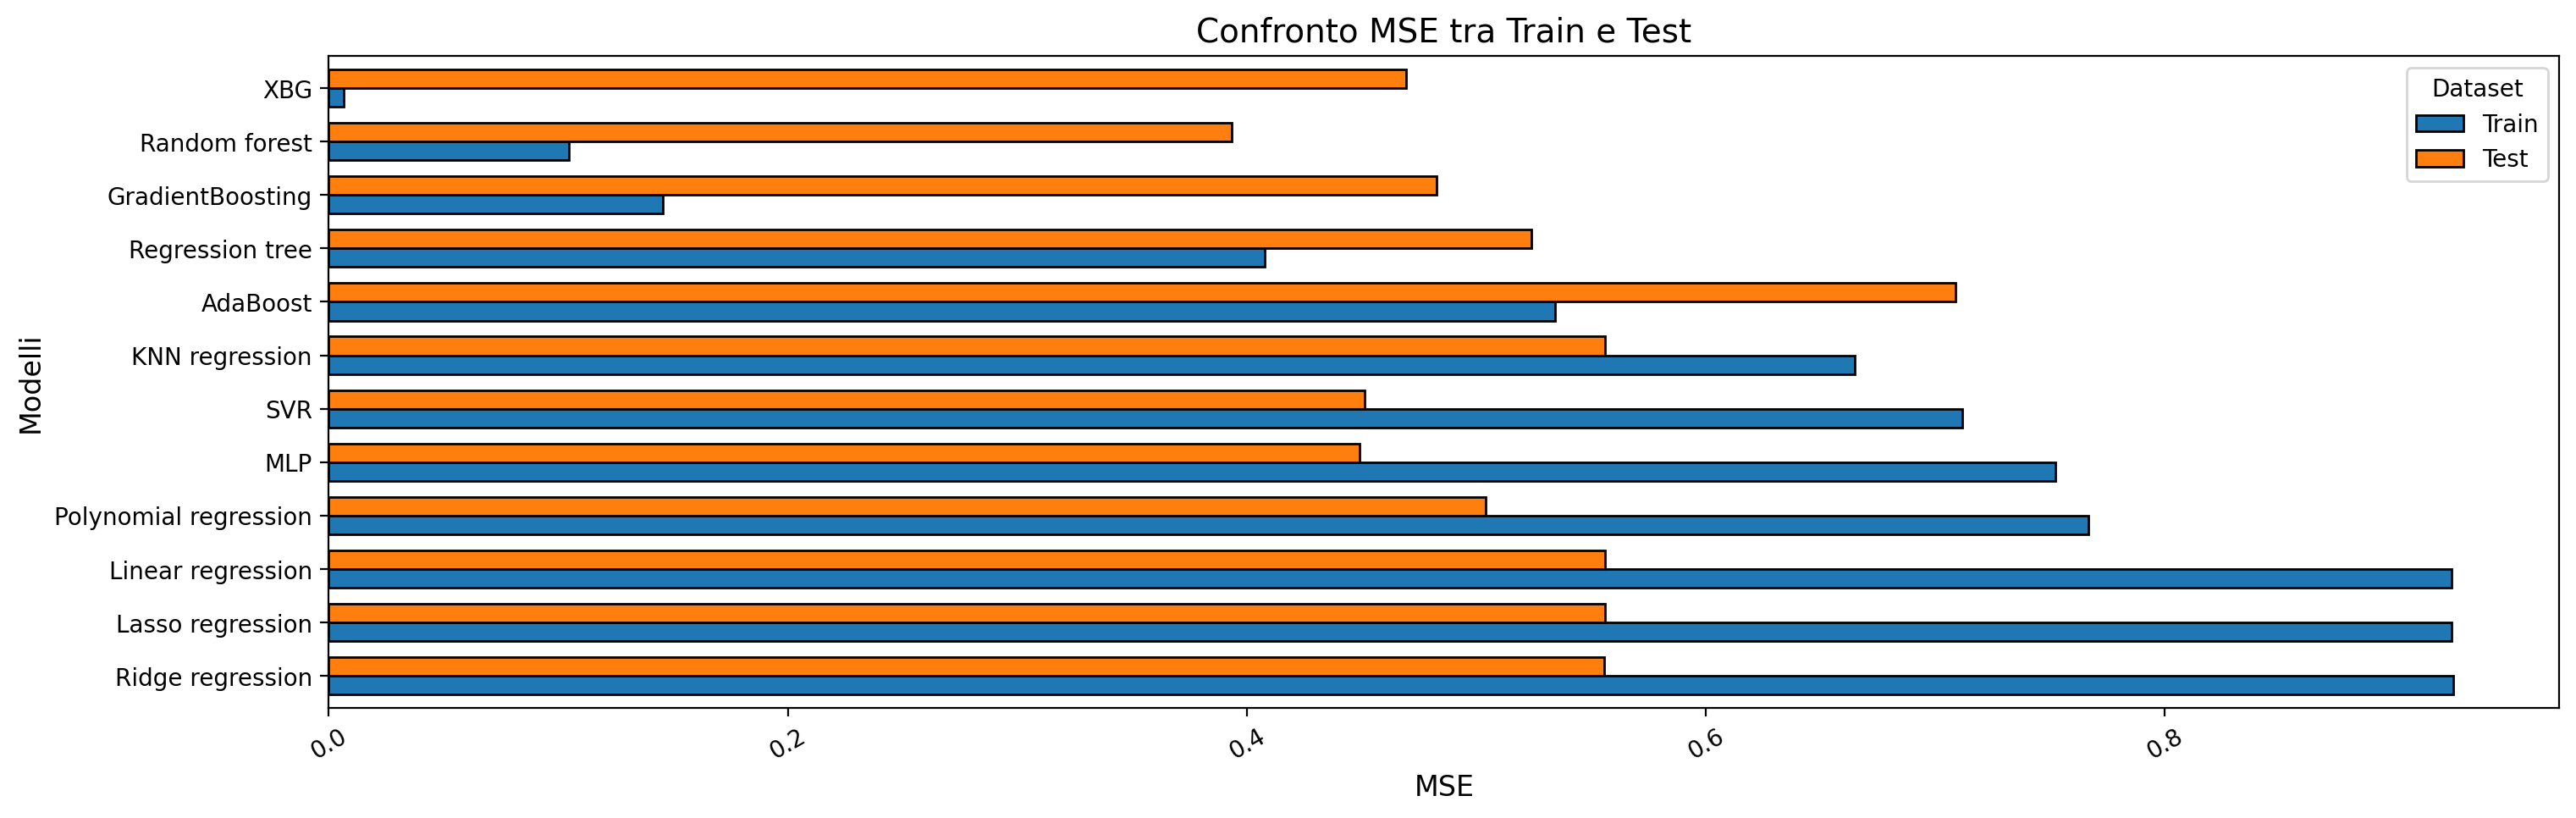

In [45]:
metric = 'MSE'

df_plot = pd.concat([
    train_metrics_df[metric].rename("Train"),
    test_metrics_df[metric].rename("Test")
], axis=1)

df_plot = df_plot.sort_values(by="Train", ascending=False)

df_plot.plot(kind="barh", figsize=(17, 5), width=0.7, edgecolor="black")

plt.title(f"Confronto {metric} tra Train e Test", fontsize=14)
plt.xlabel(metric, fontsize=12)
plt.ylabel("Modelli", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="Dataset")

plt.show()

Analysis of the bar chart comparing Mean Squared Error (MSE) across training and validation sets reveals a concerning pattern across virtually all implemented models. MSE was specifically chosen as the evaluation metric due to its property of penalizing larger errors more heavily than smaller ones, providing better insight into model reliability. The pronounced discrepancy between low training errors and significantly higher validation errors clearly indicates that most models are suffering from overfitting, demonstrating poor generalization to unseen data. This systematic issue suggests that the models are memorizing the training data rather than learning meaningful patterns that transfer to new examples. To counter this pervasive overfitting problem, several techniques could be implemented: increasing regularization strength in applicable models; reducing model complexity through simpler architectures or fewer estimators in ensemble methods; incorporating more diverse training data if available; tuning early stopping parameters based on validation performance; or employing ensemble techniques that specifically focus on improving generalization. Additionally, feature engineering approaches that reduce dimensionality while preserving signal could help create more robust representations for the learning algorithms.

In [46]:
cv_scores_df = pd.DataFrame.from_dict(cv_all_scores, orient='index')

cv_scores_df['cv_mean'] = cv_scores_df.mean(axis=1)
cv_scores_df['cv_std'] = cv_scores_df.std(axis=1, ddof=1) # ddof=1 to compute sample std

t_critical = stats.t.ppf(0.975, df=n_folds-1) # critical value t for 95% with n-1 degrees of freedom
cv_scores_df["margin_error"] = t_critical * (cv_scores_df["cv_std"] / np.sqrt(n_folds)) # compute error margin

cv_scores_df.insert(10, 'lower_b', cv_scores_df["cv_mean"] - cv_scores_df["margin_error"])
cv_scores_df.insert(12, 'upper_b', cv_scores_df["cv_mean"] + cv_scores_df["margin_error"])

cv_scores_df = cv_scores_df.sort_values(by="cv_mean", ascending=True)
cv_scores_df

,0,1,2,3,4,5,6,7,8,9,lower_b,cv_mean,upper_b,cv_std,margin_error
Regression tree,0.343374,0.257372,0.226950,0.216762,0.252570,-3.359492,-0.598449,0.302479,0.304544,0.113331,-0.971503,-0.194056,0.583391,1.086797,0.777447
AdaBoost,-0.081177,0.068974,0.056585,0.012090,0.093653,0.197744,-0.021214,0.131765,0.010617,0.151975,0.004417,0.062101,0.119786,0.080638,0.057685
KNN regression,0.045505,0.085037,0.150085,0.207202,0.236689,0.148398,0.187422,-0.025189,0.084290,0.248287,0.076815,0.136773,0.196730,0.083815,0.059958
Linear regression,0.251579,0.130369,0.177693,0.293952,0.282691,0.241496,0.246572,0.295668,0.211868,0.237534,0.201449,0.236942,0.272435,0.049616,0.035493
Lasso regression,0.251649,0.129945,0.177993,0.294971,0.282958,0.242143,0.246961,0.295347,0.212540,0.237083,0.201565,0.237159,0.272753,0.049757,0.035594
Ridge regression,0.251531,0.126648,0.179858,0.302582,0.283548,0.243760,0.253416,0.294052,0.215532,0.235362,0.202062,0.238629,0.275195,0.051116,0.036566
Polynomial regression,0.284570,0.161492,0.260852,0.330244,0.370347,0.259549,0.379741,0.336833,0.330585,0.290510,0.256845,0.300472,0.344099,0.060986,0.043627
MLP,0.329673,0.148470,0.342860,0.447976,0.455035,0.247480,0.421360,0.329573,0.377028,0.324112,0.278957,0.342357,0.405756,0.088627,0.063400
SVR,0.316862,0.153523,0.346330,0.549081,0.462432,0.383141,0.505905,0.411606,0.406721,0.324988,0.310343,0.386059,0.461775,0.105844,0.075716
Random forest,0.534093,0.345389,0.419141,0.529268,0.409630,0.185051,0.444623,0.481167,0.527424,0.377171,0.352598,0.425296,0.497993,0.101624,0.072697


Evaluation of the bar chart comparing cross-validation results using the coefficient of determination ($R^2$) reveals significant limitations across all implemented models. $R^2$ was selected as the primary metric as it directly quantifies each model's ability to explain variance in the data, with values ranging from 0 (no explanatory power) to 1 (perfect prediction). The consistently low $R^2$ values, never exceeding 0.5 across all models, indicate that even the best-performing algorithms can explain less than half of the variance present in the dataset. This underwhelming explanatory power suggests that either critical features may be missing from the current dataset, or that the underlying relationships are exceptionally complex and not fully captured by the implemented techniques. Below the bar chart, the 95% confidence intervals for performance estimates provide additional insight into the reliability of these results, quantifying the uncertainty associated with each model's performance metric. These intervals demonstrate the expected performance range when the models are applied to new, unseen data, reinforcing the conclusion that the current modeling approaches require substantial improvement to achieve satisfactory predictive capability for this particular problem domain.

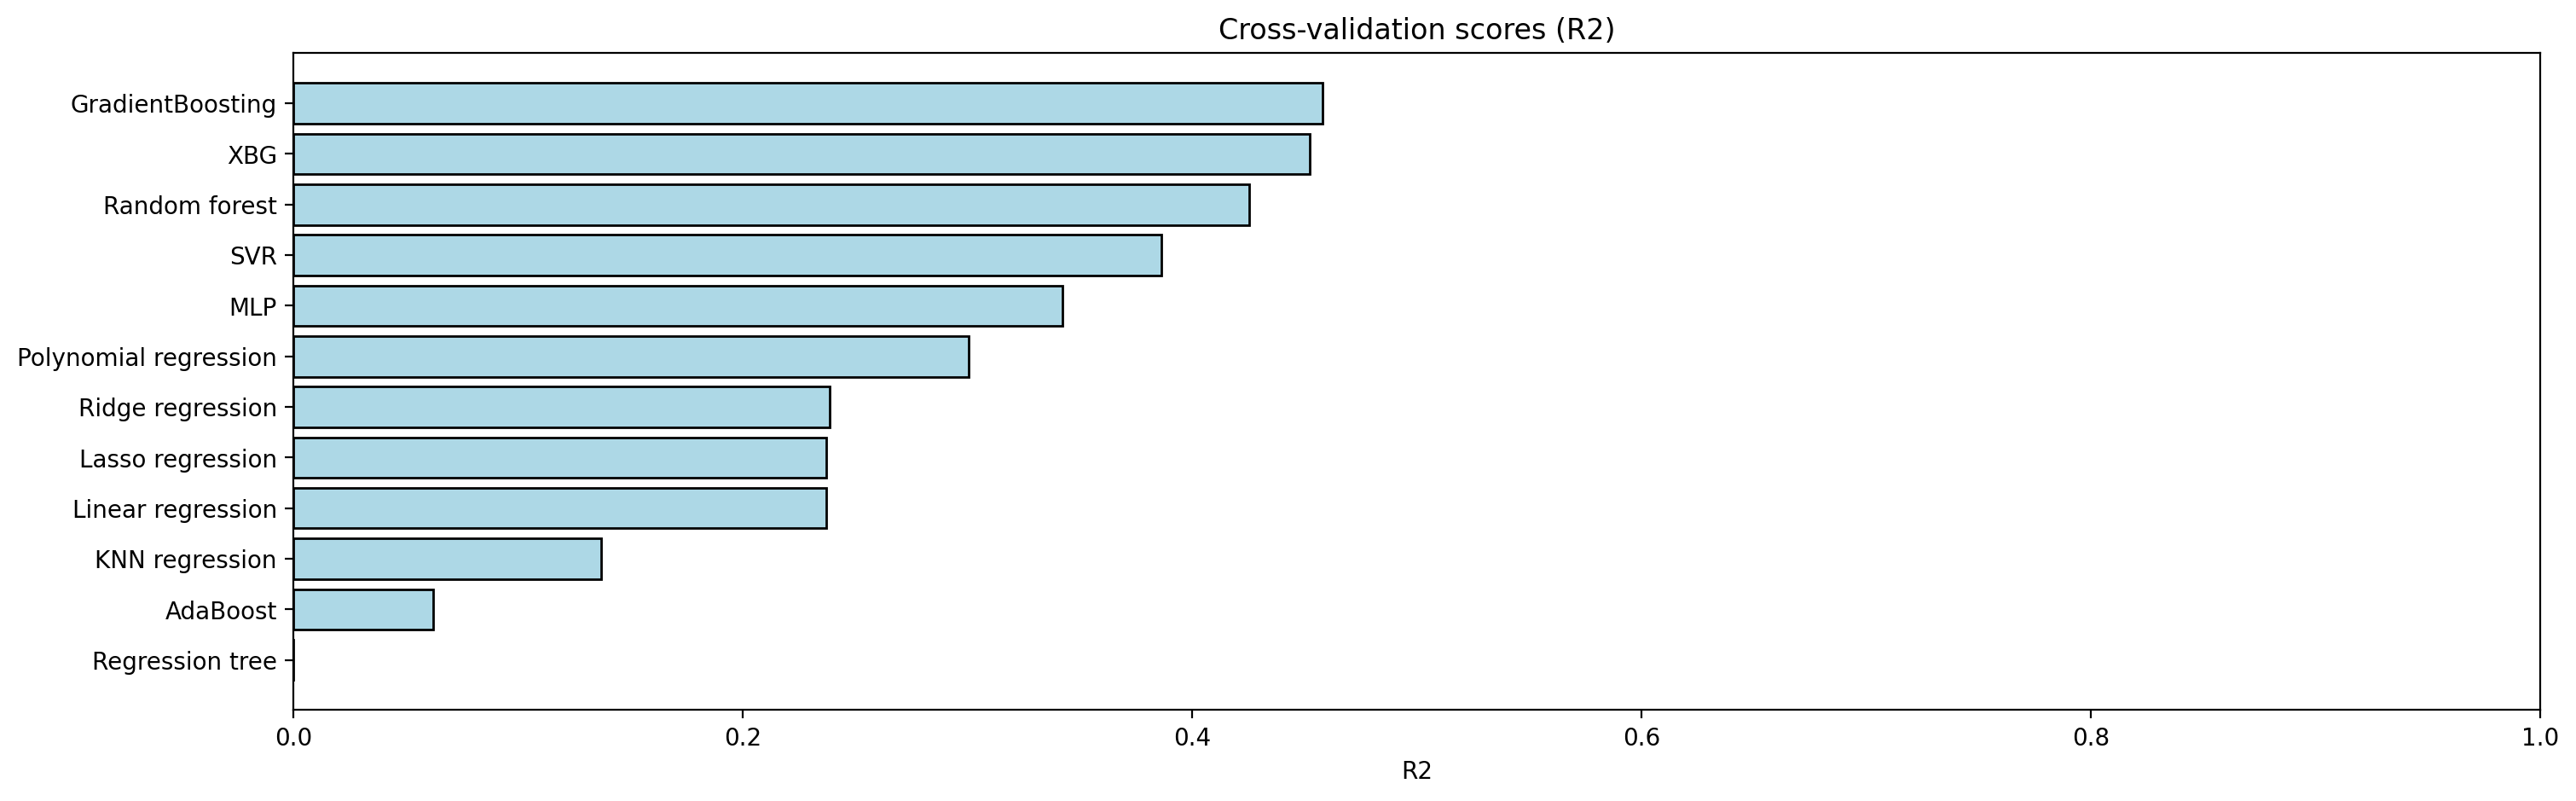

In [47]:
plt.figure(figsize=(17, 5))
plt.barh(cv_scores_df.index, cv_scores_df['cv_mean'], capsize=10, color='lightblue', edgecolor='black')

plt.xlabel('R2')
plt.title('Cross-validation scores (R2)')
plt.xlim(0, 1)
plt.show()

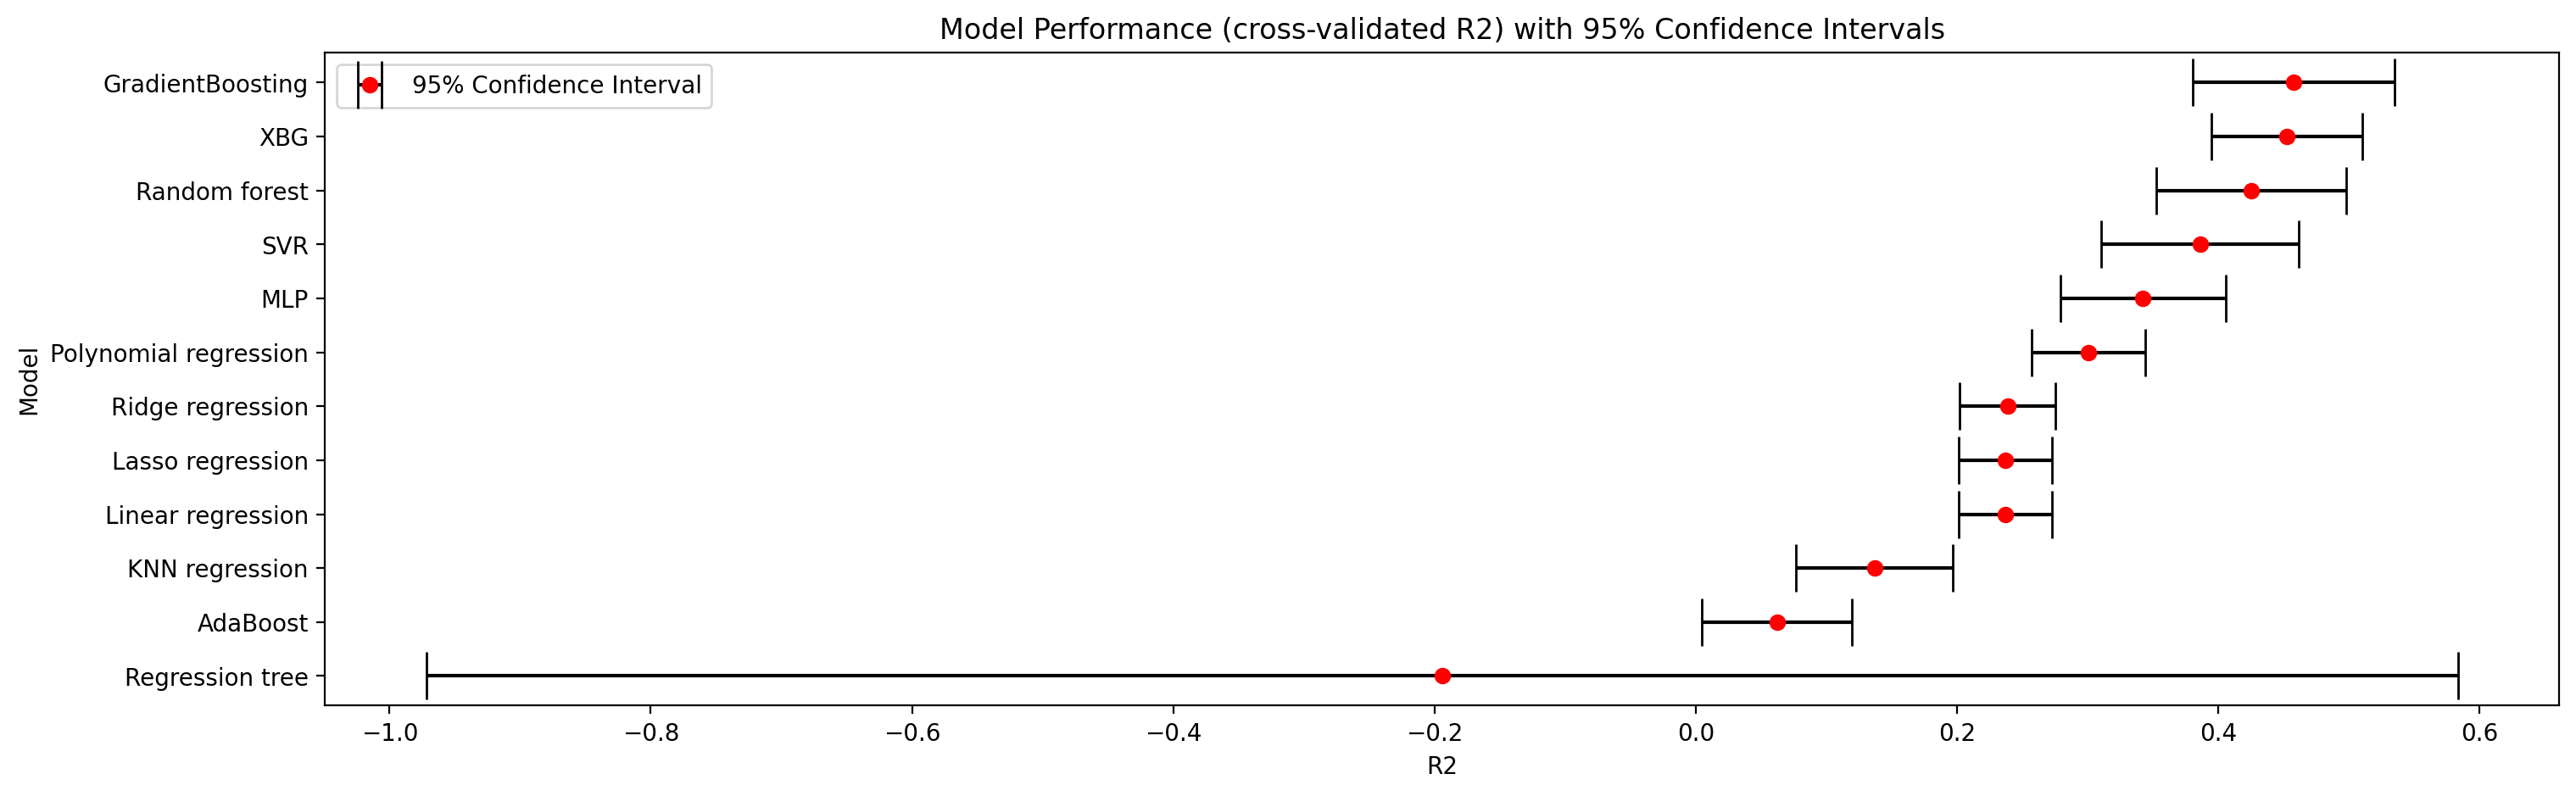

In [48]:
plt.figure(figsize=(17, 5))
plt.errorbar(cv_scores_df['cv_mean'], cv_scores_df.index, xerr=cv_scores_df['margin_error'], fmt='o', color='red', ecolor='black', capsize=10)
plt.legend(['95% Confidence Interval'])
plt.xlabel('R2')
plt.ylabel('Model')
plt.title('Model Performance (cross-validated R2) with 95% Confidence Intervals')
plt.show()

The comparative analysis of all implemented regression models reveals that the three best-performing algorithms in terms of both training and validation errors are XGBoost, Gradient Boosting, and Random Forest—representing two boosting techniques and one bagging approach. This finding aligns with the general understanding that ensemble methods often outperform individual models on complex regression tasks. Despite their relative superiority, it is important to note that all three still exhibit significant levels of overfitting, as evidenced by the substantial gap between training and validation errors. This limitation suggests that while these models capture patterns in the training data effectively, they struggle to generalize to unseen examples. The next phase of this project will focus on comprehensive hyperparameter optimization for these three top performers, exploring regularization strategies, architectural modifications, and potential feature engineering approaches. Through this systematic refinement process, the goal will be to select the optimal model that balances predictive accuracy with generalization capability, ultimately providing the most reliable solution for the problem under investigation.

A similar approach to the one detailed in this notebook has been replicated in a separate notebook utilizing Scikit-Learn’s pipeline framework. Pipelines offer a structured way to streamline the machine learning workflow by encapsulating preprocessing steps, feature transformations, and model training into a single, cohesive object. This design ensures a consistent application of transformations across both training and validation data, mitigating data leakage risks while improving code modularity and reusability. Additionally, pipelines facilitate hyperparameter tuning by integrating seamlessly with grid search and randomized search techniques, allowing for efficient optimization of preprocessing and modeling steps simultaneously. However, despite these advantages, pipelines introduce certain trade-offs, including increased computational overhead when applying transformations dynamically and reduced flexibility when fine-tuning specific preprocessing steps outside the predefined sequence. Nonetheless, their implementation in the alternate notebook provides a cleaner, more scalable framework for model experimentation, reinforcing the findings obtained in this study while ensuring reproducibility and maintainability of the workflow.